In [1]:
from counterfactualEO import *
import joblib
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
import pickle
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [5]:
# Paths for saved data and figures
datapath = '../../out/'
figpath = '../../fig/'

# Testing data generating parameters

In [320]:
prob_A = 0.3
beta_X = [1, -0.8, 4, 2]
beta_D_pre = [0.2, -1, 1, -1, 1]
beta_D_post = [0.2, -1, 1, -1, 1, 1]
beta_Y0 = [-5, 2, -3, 4, -5]
beta_Y1 = [1, -2, 3, -4, 5]

A = 'A'
X = ['X1', 'X2', 'X3', 'X4']
R = 'R'
D = 'D'
Y = 'Y'

R_preds = [A] + [XX for XX in X]
nuis_preds = [A] + [XX for XX in X] + [R]

In [321]:
## Data used to train input predictor R
dat_pre = generate_data_pre(10000, prob_A, beta_X, beta_D_pre, beta_Y0, beta_Y1,
                            trunc_pi=0.975)
R_learner = RandomForestClassifier()
R_learner.fit(dat_pre[R_preds], dat_pre['Y'])

## Data used to train fair derived predictor
data = generate_data_post(10000, prob_A, beta_X, beta_D_post, beta_Y0, beta_Y1, R_learner, trunc_pi=0.975)

In [322]:
data_params = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_post,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
    'model_R': R_learner
}

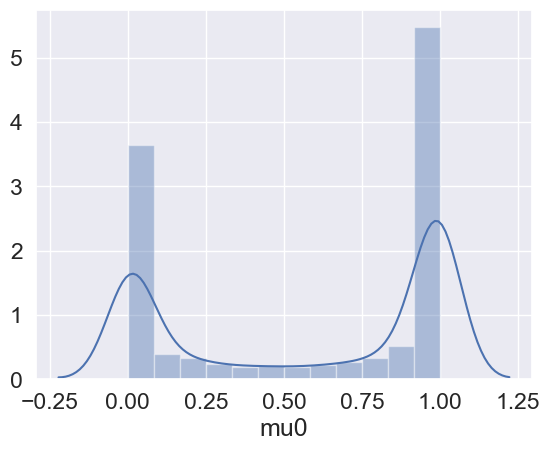

In [326]:
dat_post = generate_data_post(10000, **data_params)
sns.distplot(dat_post.mu0)

## Check data distribution

Cross-tabs for sensitive feature A, decision D, potential outcome Y0, and observable outcome Y.
---------------
D     0.0   1.0
A              
0.0  2970  4024
1.0  2302   704
---------------
Y0    0.0   1.0
A              
0.0  3411  3583
1.0   717  2289
---------------
Y     0.0   1.0
A              
0.0  2406  4588
1.0  1006  2000
---------------

How often Y = Y0: 0.583 

Properties of input predictor R

-------------------------
Confusion matrix for Y, R
-------------------------
[[0.1047 0.2365]
 [0.0924 0.5664]] 

------------------------------
Classification report for Y, R
------------------------------
              precision    recall  f1-score   support

     Group 0       0.53      0.31      0.39      3412
     Group 1       0.71      0.86      0.77      6588

    accuracy                           0.67     10000
   macro avg       0.62      0.58      0.58     10000
weighted avg       0.65      0.67      0.64     10000
 

-------------------------------
Classification repo

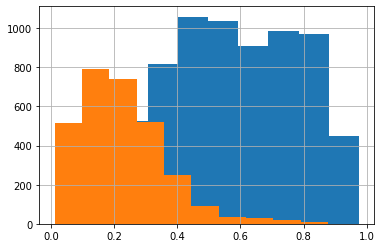

In [20]:
check_data_post(data)

## Check nuisance parameter estimation

In [327]:
## Are the nuisance parameters too easy to learn? Then won't see root-n progress.

learner_pi = RandomForestClassifier()
learner_mu = RandomForestClassifier()

nuis = train_nuisance(train, test, A, X, R, D, Y, learner_pi, learner_mu, trunc_pi=0.975)

NameError: name 'train' is not defined

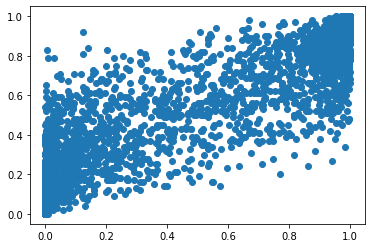

In [273]:
plt.plot(test['mu0'], nuis['muhat0'], marker = 'o', linestyle = 'none')

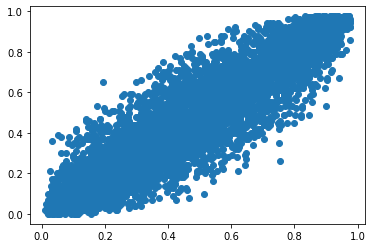

In [275]:
plt.plot(test['pi'], nuis['pihat'], marker = 'o', linestyle = 'none')

In [292]:
## Are the coefficient estimates too good?
data_params = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_post,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
    'model_R': R_learner
}

learner_pi = RandomForestClassifier()
learner_mu = RandomForestClassifier()

optim_params = {
    'A': 'A', 'X': X, 'R': 'R', 'D': 'D', 'Y': 'Y',
    'learner_pi': learner_pi_nonpar,
    'learner_mu': learner_mu_nonpar,
    'epsilon_pos': 0.10, 'epsilon_neg': 0.10
}

res = simulate(100, data_params, optim_params, 'doubly_robust')


In [293]:
res

{'theta': Variable((4,)),
 'loss_coefs': array([-0.03864044,  0.02647503,  0.0182    , -0.22172759]),
 'fairness_coefs_pos': [0.17390877089116252,
  0.8260912291088375,
  -0.6730470767324939,
  -0.3269529232675062],
 'fairness_coefs_neg': [-0.27506225199329304,
  -0.724937748006707,
  0.04417179557946013,
  0.9558282044205398],
 'metrics':     Metric     Value       Var Outcome Predictor            Est
 0     Risk  0.338690  0.001484      Y0   Derived  doubly_robust
 1     FPR0  0.905401  0.000000      Y0   Derived  doubly_robust
 2     FPR1  0.699964  0.000000      Y0   Derived  doubly_robust
 3     FNR0  0.881537  0.000000      Y0   Derived  doubly_robust
 4     FNR1  0.987498  0.000000      Y0   Derived  doubly_robust
 5  gap_FPR  0.205438  0.000000      Y0   Derived  doubly_robust
 6  gap_FNR  0.105962  0.000000      Y0   Derived  doubly_robust}

In [297]:
res_true = simulate_true(10000, data_params)

In [298]:
res_true

{'theta': array([0.99999998, 0.85942739, 0.70374033, 1.        ]),
 'loss_coefs': array([-0.00414662, -0.01475737,  0.0460602 , -0.19287878]),
 'fairness_coefs_pos': array([ 0.16108172,  0.83891828, -0.77662338, -0.22337662]),
 'fairness_coefs_neg': array([ 0.15333333,  0.84666667, -0.05924596, -0.94075404]),
 'metrics':     Metric     Value       Var Outcome
 0     Risk  0.406562  0.000016      Y0
 1     FPR0  0.881119  0.000000      Y0
 2     FPR1  0.773078  0.000000      Y0
 3     FNR0  0.882001  0.000000      Y0
 4     FNR1  0.981341  0.000000      Y0
 5  gap_FPR  0.108041  0.000000      Y0
 6  gap_FNR  0.099340  0.000000      Y0}

## Check noise added to nuisance parameters

Needs to be the right size to meaningfully illustrate convergence.

### Adding noise directly to pi and mu0

In [ ]:
pred_best_1 = get_optimal(data_params, epsilon_pos, epsilon_neg, 50000)
theta_best_1 = pred_best_1['theta']
pred_best_1

In [418]:
obj_true

array([ 0.00171647, -0.00046777,  0.03701089, -0.19381562])

In [419]:
pred_best_1['obj']

array([ 0.00068677, -0.00227648,  0.03845553, -0.19505431])

In [420]:
pos_true

array([ 0.1982051 ,  0.8017949 , -0.78326572, -0.21673428])

In [421]:
pred_best_1['pos']

array([ 0.19864124,  0.80135876, -0.79075334, -0.20924666])

In [422]:
neg_true

array([-0.19399585, -0.80600415,  0.08468183,  0.91531817])

In [423]:
pred_best_1['neg']

array([-0.19577824, -0.80422176,  0.08182896,  0.91817104])

In [415]:
## Setting noise coefficient to 50
n_arr = [200, 1000, 5000, 20000]
mc_reps = 10
res_noise50, _ = add_noise_expit(n_arr, mc_reps, data_params, obj_true, pos_true, neg_true, trunc_pi=0.975)

Sample size 200:
...Round 0
...Round 10
Sample size 1000:
...Round 20
...Round 30
Sample size 5000:
...Round 40
...Round 50
Sample size 20000:
...Round 60
...Round 70


In [435]:
res_noise50 = copy.deepcopy(res_noise)

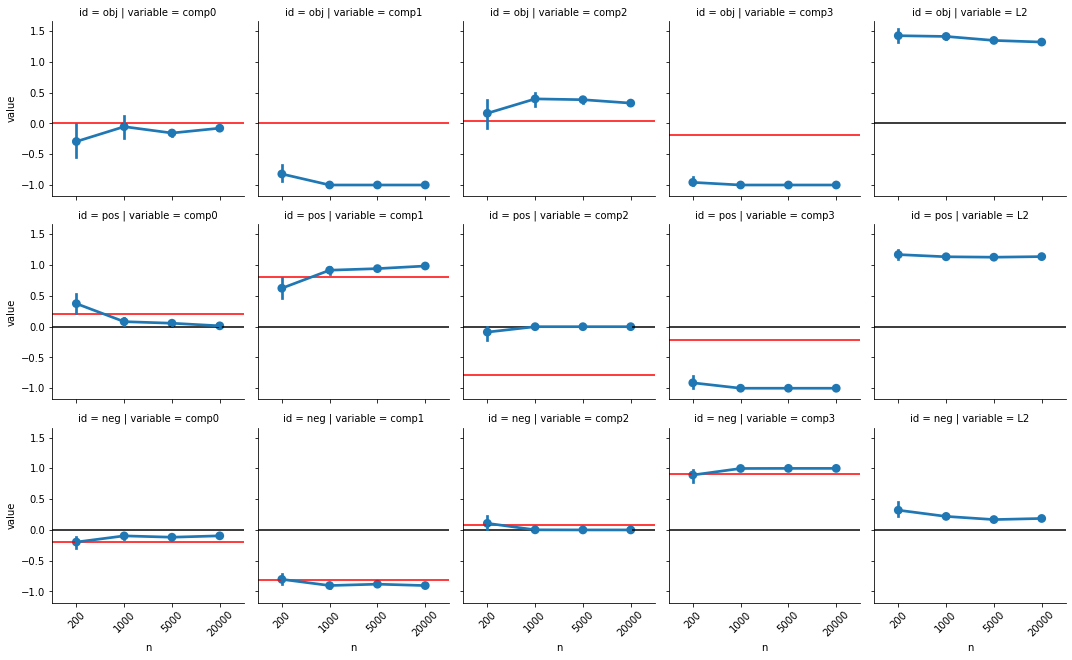

In [436]:
plot_noise(res_noise50, obj_true, pos_true, neg_true)

In [578]:
res_noise50.to_csv('../out/res_noise50.csv', index = False)

In [434]:
## Setting noise coefficient to 10
n_arr = [200, 1000, 5000, 20000]
mc_reps = 10
res_noise10, _ = add_noise_expit(n_arr, mc_reps, data_params, obj_true, pos_true, neg_true, trunc_pi=0.975)

Sample size 200:
...Round 0
Sample size 1000:
...Round 10
Sample size 5000:
...Round 20
Sample size 20000:
...Round 30


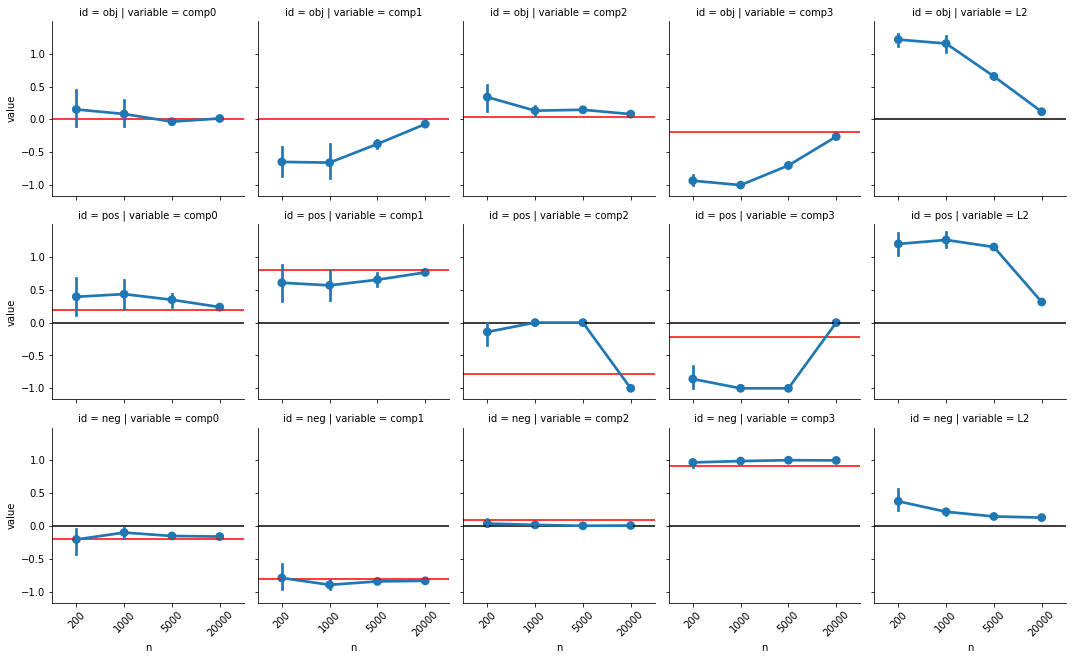

In [437]:
plot_noise(res_noise10, obj_true, pos_true, neg_true)

In [579]:
res_noise10.to_csv('../out/res_noise10.csv', index = False)

### Adding noise to the logit-transformed pi and mu0 

In [30]:
## Get optimal predictor
pred_best_1 = get_optimal(data_params, 0.05, 0.05, 50000)
theta_best_1 = pred_best_1['theta']
pred_best_1

{'theta': array([0.59817643, 0.99999998, 0.84274392, 1.        ]),
 'obj': array([ 0.00317755, -0.00528099,  0.03774542, -0.19410518]),
 'pos': array([ 0.15852512,  0.84147488, -0.72301905, -0.27698095]),
 'neg': array([-0.14852946, -0.85147054,  0.06157249,  0.93842751])}

In [32]:
obj_true = pred_best_1['obj']
pos_true = pred_best_1['pos']
neg_true = pred_best_1['neg']

In [48]:
## Noise coefficient of 10
n_arr = [200, 1000, 5000, 20000]
mc_reps = 10
res_noise10_2 = add_noise_logit(n_arr, mc_reps, data_params, obj_true, pos_true,
                                neg_true, noise_coef=10, trunc_pi=0.975)

Sample size 200:
...Round 0
Sample size 1000:
...Round 10
Sample size 5000:
...Round 20
Sample size 20000:
...Round 30


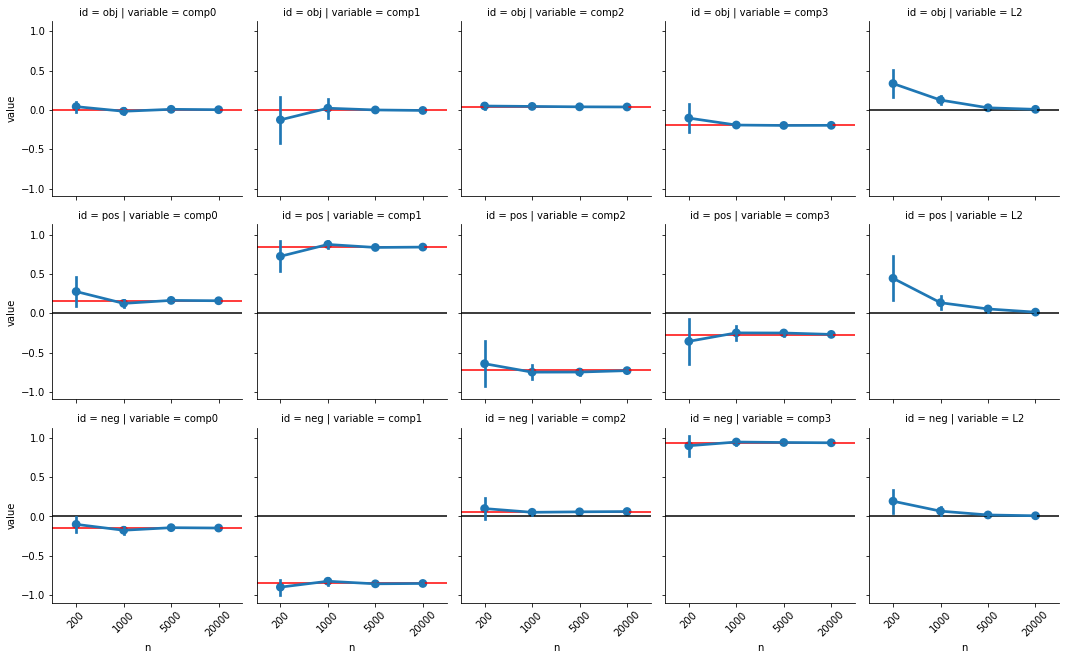

In [60]:
plot_noise(res_noise10_2, obj_true, pos_true, neg_true, ci = 'sd')

In [55]:
## Noise coefficient of 30
n_arr = [200, 1000, 5000, 20000]
mc_reps = 20
res_noise30_2 = add_noise_logit(n_arr, mc_reps, data_params, obj_true, pos_true,
                                neg_true, noise_coef=30, trunc_pi=0.975)

Sample size 200:
...Round 0
...Round 10
Sample size 1000:
...Round 20
...Round 30
Sample size 5000:
...Round 40
...Round 50
Sample size 20000:
...Round 60
...Round 70


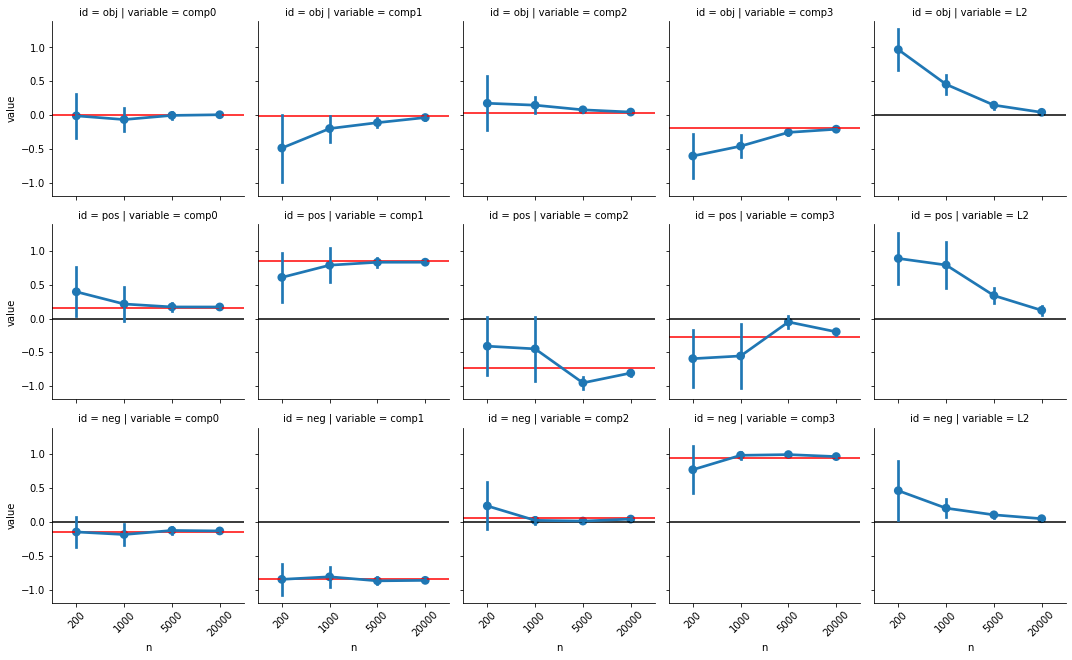

In [58]:
plot_noise(res_noise30_2, obj_true, pos_true, neg_true, ci = 'sd')

In [52]:
## Noise coefficient of 50
n_arr = [200, 1000, 5000, 20000]
mc_reps = 10
res_noise50_2 = add_noise_logit(n_arr, mc_reps, data_params, obj_true, pos_true,
                                neg_true, noise_coef=50, trunc_pi=0.975)

Sample size 200:
...Round 0
Sample size 1000:
...Round 10
Sample size 5000:
...Round 20
Sample size 20000:
...Round 30


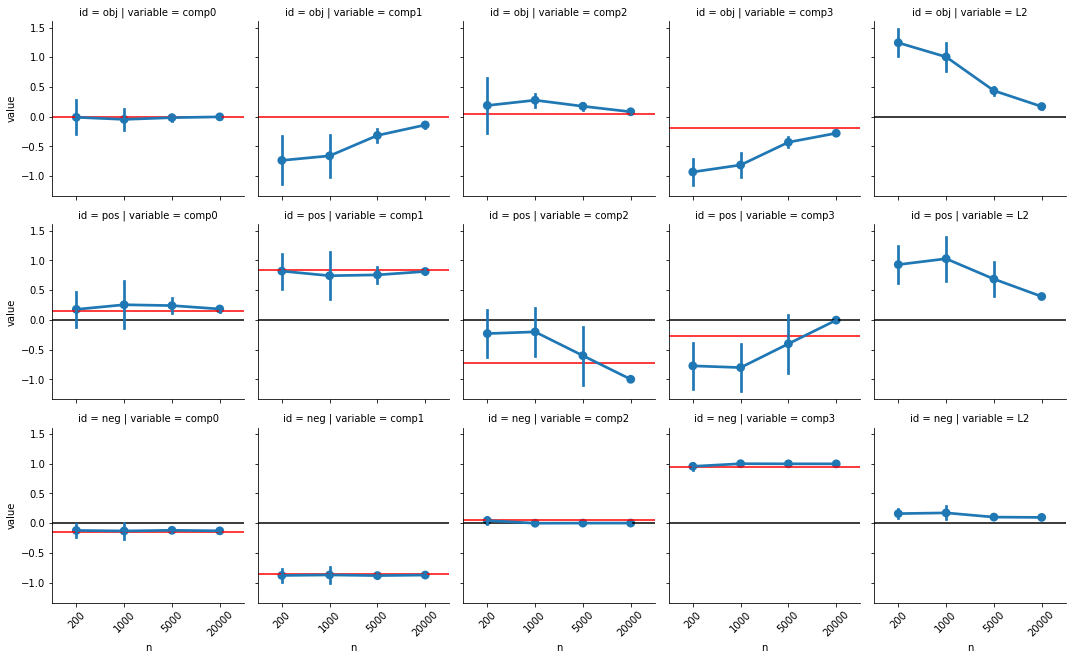

In [59]:
plot_noise(res_noise50_2, obj_true, pos_true, neg_true, ci = 'sd')

In [663]:
## Checking generate_data_post_noisy
data_test10 = generate_data_post_noisy(10000, 10, **data_params)
data_test30 = generate_data_post_noisy(10000, 30, **data_params)

In [670]:
print(pearsonr(data_test10['pi'], data_test10['pihat']))
print(pearsonr(data_test30['pi'], data_test30['pihat']))
print(pearsonr(data_test10['mu0'], data_test10['muhat0']))
print(pearsonr(data_test30['mu0'], data_test30['muhat0']))

(0.9297723853869436, 0.0)
(0.6319392841627037, 0.0)
(0.9831968687821788, 0.0)
(0.8833417390115376, 0.0)


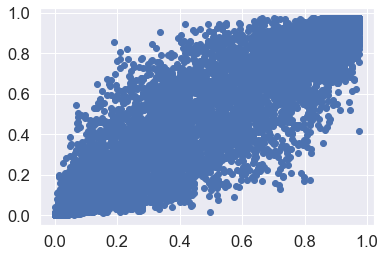

In [664]:
plt.plot(data_test10['pi'], data_test10['pihat'], marker = 'o', linestyle = 'none')

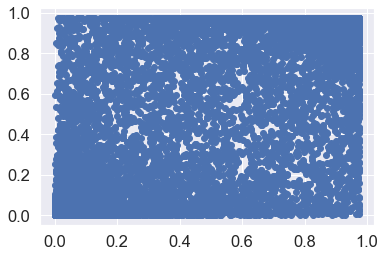

In [665]:
plt.plot(data_test30['pi'], data_test30['pihat'], marker = 'o', linestyle = 'none')

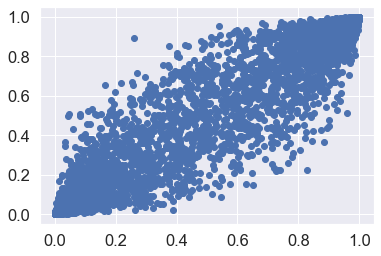

In [671]:
plt.plot(data_test10['mu0'], data_test10['muhat0'], marker = 'o', linestyle = 'none')

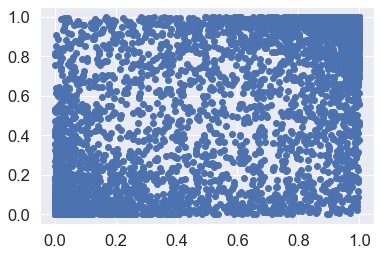

In [672]:
plt.plot(data_test30['mu0'], data_test30['muhat0'], marker = 'o', linestyle = 'none')

# Simulations Setup

## Pre-data generation parameters

In [2]:
prob_A = 0.3
beta_X = [1, -0.8, 4, 2]
beta_D_pre = [0.2, -1, 1, -1, 1]
beta_D_post = [0.2, -1, 1, -1, 1, 1]
beta_Y0 = [-5, 2, -3, 4, -5]
# beta_Y0 = [-4, 2/5.0, -3/5.0, 4/5.0, -1]
beta_Y1 = [1, -2, 3, -4, 5]

A = 'A'
X = ['X1', 'X2', 'X3', 'X4']
R = 'R'
D = 'D'
Y = 'Y'

R_preds = [A] + [XX for XX in X]

## Train input predictor R

In [225]:
random.seed(42)

dat_pre = generate_data_pre(10000, prob_A, beta_X, beta_D_pre, beta_Y0, beta_Y1, trunc_pi=0.975)
R_learner = RandomForestClassifier()
R_learner.fit(dat_pre[R_preds], dat_pre['Y'])

joblib.dump(R_learner, '../out/R_learner.model')

['../out/R_learner.model']

## Post-data generation parameters

In [4]:
## Read in previously trained predictor R
with open('../out/R_learner.model', 'rb') as file_in:
    R_learner = joblib.load(file_in)

data_params = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_post,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
    'model_R': R_learner
}

# Task (1) Simulations

## Read in previous results

In [2]:
##############
### Task 1 ###
##############

data_val = pd.read_csv('../out/data_val.csv')

## Optimal predictors
with open('../out/task1/pred_best_1.pickle', 'rb') as file_in:
    pred_best_1 = pickle.load(file_in)
with open('../out/task1/metrics_best_1.pickle', 'rb') as file_in:
    metrics_best_1 = pickle.load(file_in)
with open('../out/task1/pred_best_2.pickle', 'rb') as file_in:
    pred_best_2 = pickle.load(file_in)
with open('../out/task1/metrics_best_2.pickle', 'rb') as file_in:
    metrics_best_2 = pickle.load(file_in)
with open('../out/task1/pred_trivial.pickle', 'rb') as file_in:
    pred_trivial = pickle.load(file_in)
with open('../out/task1/metrics_trivial.pickle', 'rb') as file_in:
    metrics_trivial = pickle.load(file_in)
    
## Estimated fair predictors: doubly robust
with open('../out/task1/res1_10.pickle', 'rb') as file_in:
    res1_10 = pickle.load(file_in) 
with open('../out/task1/res1_30.pickle', 'rb') as file_in:
    res1_30 = pickle.load(file_in)
metrics1_10 = pd.read_csv('../out/task1/metrics1_10.csv')
metrics1_30 = pd.read_csv('../out/task1/metrics1_30.csv')

with open('../out/task1/res2_10.pickle', 'rb') as file_in:
    res2_10 = pickle.load(file_in) 
with open('../out/task1/res2_30.pickle', 'rb') as file_in:
    res2_30 = pickle.load(file_in)
metrics2_10 = pd.read_csv('../out/task1/metrics2_10.csv')
metrics2_30 = pd.read_csv('../out/task1/metrics2_30.csv')

with open('../out/task1/res3_10.pickle', 'rb') as file_in:
    res3_10 = pickle.load(file_in) 
with open('../out/task1/res3_30.pickle', 'rb') as file_in:
    res3_30 = pickle.load(file_in)
metrics3_10 = pd.read_csv('../out/task1/metrics3_10.csv')
metrics3_30 = pd.read_csv('../out/task1/metrics3_30.csv')

metrics_comb = pd.read_csv('../out/task1/metrics_comb.csv')
metrics_comb_25 = pd.read_csv('../out/task1/metrics_comb_25.csv')
metrics_comb_sqrt = pd.read_csv('../out/task1/metrics_comb_sqrt.csv')
metrics_comb_75 = pd.read_csv('../out/task1/metrics_comb_75.csv')
metrics_comb_100 = pd.read_csv('../out/task1/metrics_comb_100.csv')


##############
### Task 2 ###
##############

## Estimated fair predictors: plugin
with open('../out/task1/res1_10_sr.pickle', 'rb') as file_in:
    res1_10_sr = pickle.load(file_in) 
with open('../out/task1/res1_30_sr.pickle', 'rb') as file_in:
    res1_30_sr = pickle.load(file_in)
metrics1_10_sr = pd.read_csv('../out/task1/metrics1_10_sr.csv')
metrics1_30_sr = pd.read_csv('../out/task1/metrics1_30_sr.csv')

with open('../out/task1/res2_10_sr.pickle', 'rb') as file_in:
    res2_10_sr = pickle.load(file_in) 
with open('../out/task1/res2_30_sr.pickle', 'rb') as file_in:
    res2_30_sr = pickle.load(file_in)
metrics2_10_sr = pd.read_csv('../out/task1/metrics2_10_sr.csv')
metrics2_30_sr = pd.read_csv('../out/task1/metrics2_30_sr.csv')

with open('../out/task1/res3_10_sr.pickle', 'rb') as file_in:
    res3_10_sr = pickle.load(file_in) 
with open('../out/task1/res3_30_sr.pickle', 'rb') as file_in:
    res3_30_sr = pickle.load(file_in)
metrics3_10_sr = pd.read_csv('../out/task1/metrics3_10_sr.csv')
metrics3_30_sr = pd.read_csv('../out/task1/metrics3_30_sr.csv')

metrics_comb_sr = pd.read_csv('../out/task1/metrics_comb_sr.csv')
metrics_comb_sr_25 = pd.read_csv('../out/task1/metrics_comb_sr_25.csv')
metrics_comb_sr_sqrt = pd.read_csv('../task1/out/metrics_comb_sr_sqrt.csv')
metrics_comb_sr_75 = pd.read_csv('../out/task1/metrics_comb_sr_75.csv')
metrics_comb_sr_100 = pd.read_csv('../out/task1/metrics_comb_sr_100.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../out/task1/pred_best_1.pickle'

## Get optimal fair predictors

In [14]:
# data_val = generate_data_post(500000, **data_params)
# data_val.to_csv('../out/data_val.csv', index = False)

### Setting 1: equal epsilon values

In [6]:
## Get optimal predictor
epsilon_pos = 0.05
epsilon_neg = 0.05

pred_best_1 = get_optimal(data_params, epsilon_pos, epsilon_neg, 500000)
metrics_best_1 = metrics(pred_best_1['theta'], data_val, outcome='mu0', ci=None)

In [7]:
with open('../out/task1/pred_best_1.pickle', 'wb') as file_out:
    pickle.dump(pred_best_1, file_out)
with open('../out/task1/metrics_best_1.pickle', 'wb') as file_out:
    pickle.dump(metrics_best_1, file_out)

### Setting 2: different epsilon values

In [8]:
## Get optimal predictor
epsilon_pos = 0.10
epsilon_neg = 0.20

pred_best_2 = get_optimal(data_params, epsilon_pos, epsilon_neg, 500000)
metrics_best_2 = metrics(pred_best_2['theta'], data_val, outcome = 'mu0', ci=None)

In [9]:
with open('../out/task1/pred_best_2.pickle', 'wb') as file_out:
    pickle.dump(pred_best_2, file_out)
with open('../out/task1/metrics_best_2.pickle', 'wb') as file_out:
    pickle.dump(metrics_best_2, file_out)

### Setting 3: no fairness constraints

In [10]:
epsilon_pos = 1.0
epsilon_neg = 1.0

pred_trivial = get_optimal(data_params, epsilon_pos, epsilon_neg, 500000)
metrics_trivial = metrics(pred_trivial['theta'], data_val, outcome = 'mu0', ci=None)

In [11]:
with open('../out/task1/pred_trivial.pickle', 'wb') as file_out:
    pickle.dump(pred_trivial, file_out)
with open('../out/task1/metrics_trivial.pickle', 'wb') as file_out:
    pickle.dump(metrics_trivial, file_out)

In [12]:
metrics_best = pd.concat([metrics_best_1, metrics_best_2, metrics_trivial],
                        keys = ['setting1', 'setting2', 'trivial'])
metrics_best = metrics_best.reset_index().rename(columns = {'level_0': 'setting'}).drop(columns = 'level_1')
with open('../out/task1/metrics_best.pickle', 'wb') as file_out:
    pickle.dump(metrics_best, file_out)

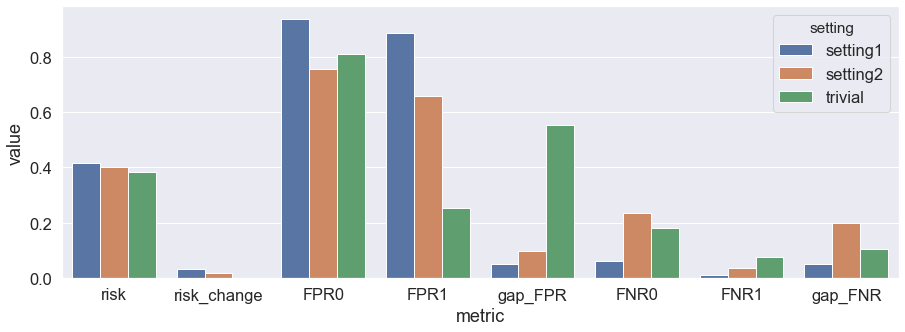

In [17]:
plt.figure(figsize=(15,5))
sns.set(font_scale = 1.5)
g = sns.barplot(x = 'metric', y = 'value', hue = 'setting', data = metrics_best)
g.get_figure().savefig('../fig/task1/optimal_predictors.pdf')

In [18]:
risk_best1 = metrics_best_1.loc[metrics_best_1['metric'] == 'risk', 'value'].values[0]
risk_best2 = metrics_best_2.loc[metrics_best_2['metric'] == 'risk', 'value'].values[0]
risk_best3 = metrics_trivial.loc[metrics_trivial['metric'] == 'risk', 'value'].values[0]

In [19]:
risk_change1 = metrics_best_1.loc[metrics_best_1['metric'] == 'risk_change', 'value'].values[0]
risk_change2 = metrics_best_2.loc[metrics_best_2['metric'] == 'risk_change', 'value'].values[0]
risk_change3 = metrics_trivial.loc[metrics_trivial['metric'] == 'risk_change', 'value'].values[0]

## Get estimated fair predictors: doubly robust

In [21]:
n_arr = [100, 200, 500, 1000, 5000, 20000]
mc_reps = 500

### Setting 1: equal epsilon values 

In [294]:
# noise_coef = 10
# res1_10 = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.05,
#                    epsilon_neg = 0.05) for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [53]:
noise_coef = 30
res1_30 = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.05,
                   epsilon_neg = 0.05) for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [54]:
# with open('../out/task1/res1_10.pickle', 'wb') as file_out:
#     pickle.dump(res1_10, file_out)
    
with open('../out/task1/res1_30.pickle', 'wb') as file_out:
    pickle.dump(res1_30, file_out)

In [56]:
# metrics1_10 = metrics_to_df(res1_10, n_arr, 'Setting1_Noise10', data_val, ci=None)
metrics1_30 = metrics_to_df(res1_30, n_arr, 'Setting1_Noise30', data_val, ci=None)

In [57]:
# metrics1_10.to_csv('../out/metrics1_10.csv', index = False)
metrics1_30.to_csv('../out/metrics1_30.csv', index = False)

### Setting 2: different epsilon values

In [41]:
# noise_coef = 10
# res2_10 = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.10,
#                    epsilon_neg = 0.20) for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [22]:
noise_coef = 30
res2_30 = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.10,
                   epsilon_neg = 0.20) for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [23]:
# with open('../out/res2_10.pickle', 'wb') as file_out:
#     pickle.dump(res2_10, file_out)
    
with open('../out/task1/res2_30.pickle', 'wb') as file_out:
    pickle.dump(res2_30, file_out)

In [24]:
# metrics2_10 = metrics_to_df(res2_10, n_arr, 'Setting2_Noise10', data_val)
metrics2_30 = metrics_to_df(res2_30, n_arr, 'Setting2_Noise30', data_val)

In [25]:
# metrics2_10.to_csv('../out/metrics2_10.csv', index = False)
metrics2_30.to_csv('../out/task1/metrics2_30.csv', index = False)

### Setting 3: no fairness constraints

In [ ]:
# noise_coef = 10
# res3_10 = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 1.0,
#                    epsilon_neg = 1.0) for nn in n_arr]

In [ ]:
noise_coef = 30
res3_30 = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 1.0,
                   epsilon_neg = 1.0) for nn in n_arr]

In [416]:
# with open('../out/task1/res3_10.pickle', 'wb') as file_out:
#     pickle.dump(res3_10, file_out)
    
with open('../out/task1/res3_30.pickle', 'wb') as file_out:
    pickle.dump(res3_30, file_out)

In [611]:
# metrics3_10 = metrics_to_df(res3_10, n_arr, 'Trivial_Noise10', data_val, ci=None)
metrics3_30 = metrics_to_df(res3_30, n_arr, 'Trivial_Noise30', data_val, ci=None)

In [415]:
# metrics3_10.to_csv('../out/metrics3_10.csv', index = False)
metrics3_30.to_csv('../out/task1/metrics3_30.csv', index = False)

## Plot combined results: doubly robust

In [386]:
metrics_comb = pd.concat([metrics1_10, metrics1_30, metrics2_10, metrics2_30,
                         metrics3_10, metrics3_30])
metrics_comb = metrics_comb.drop(columns='outcome')

In [101]:
metrics_comb.to_csv('../out/task1/metrics_comb.csv', index = False)

### Unscaled

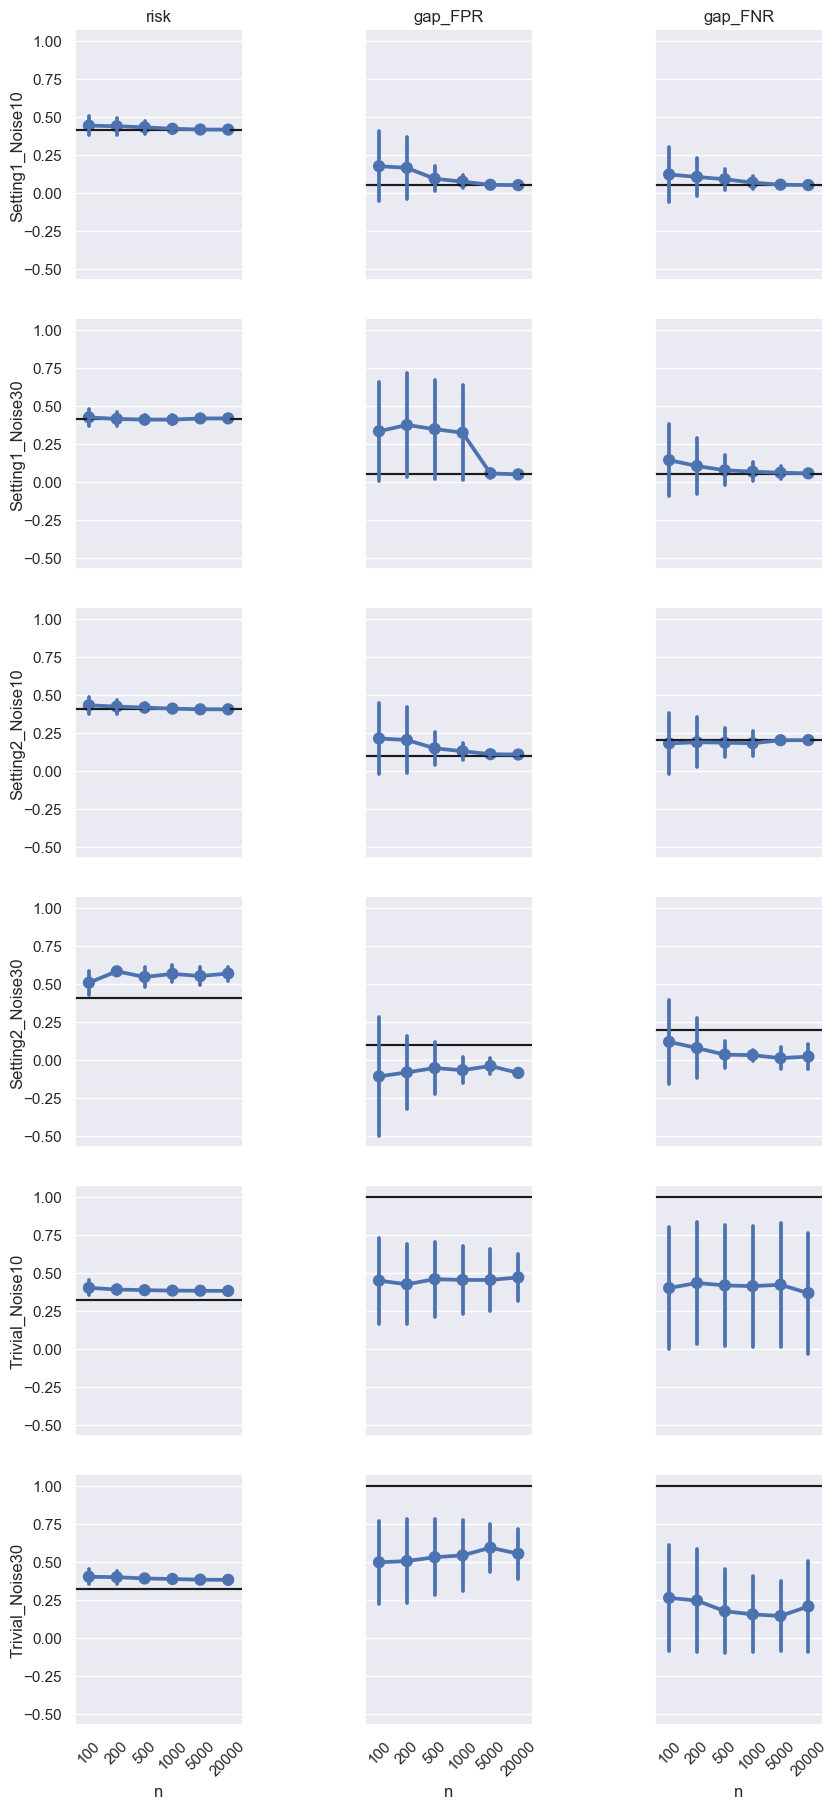

In [387]:
sns.set()
plot_metrics2(metrics_comb, n_arr, row = 'setting', col = 'metric',
              risk_best = (risk_best1, risk_best1, risk_best2, risk_best2, risk_best3, risk_best3),
              epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0))

### Scaled by $n^{0.25}$

In [91]:
metrics_comb_25 = transform_metrics(metrics_comb, risk=(risk_best1, risk_best1,
                                                          risk_best2, risk_best2,
                                                          risk_best3, risk_best3),
                                      risk_change=(risk_change1, risk_change1,
                                                          risk_change2, risk_change2,
                                                          risk_change3, risk_change3),
                                      epsilon_pos=(0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
                                      epsilon_neg=(0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
                                      scale=0.25)

In [92]:
metrics_comb_25.to_csv('../out/task1/metrics_comb_25.csv', index = False)

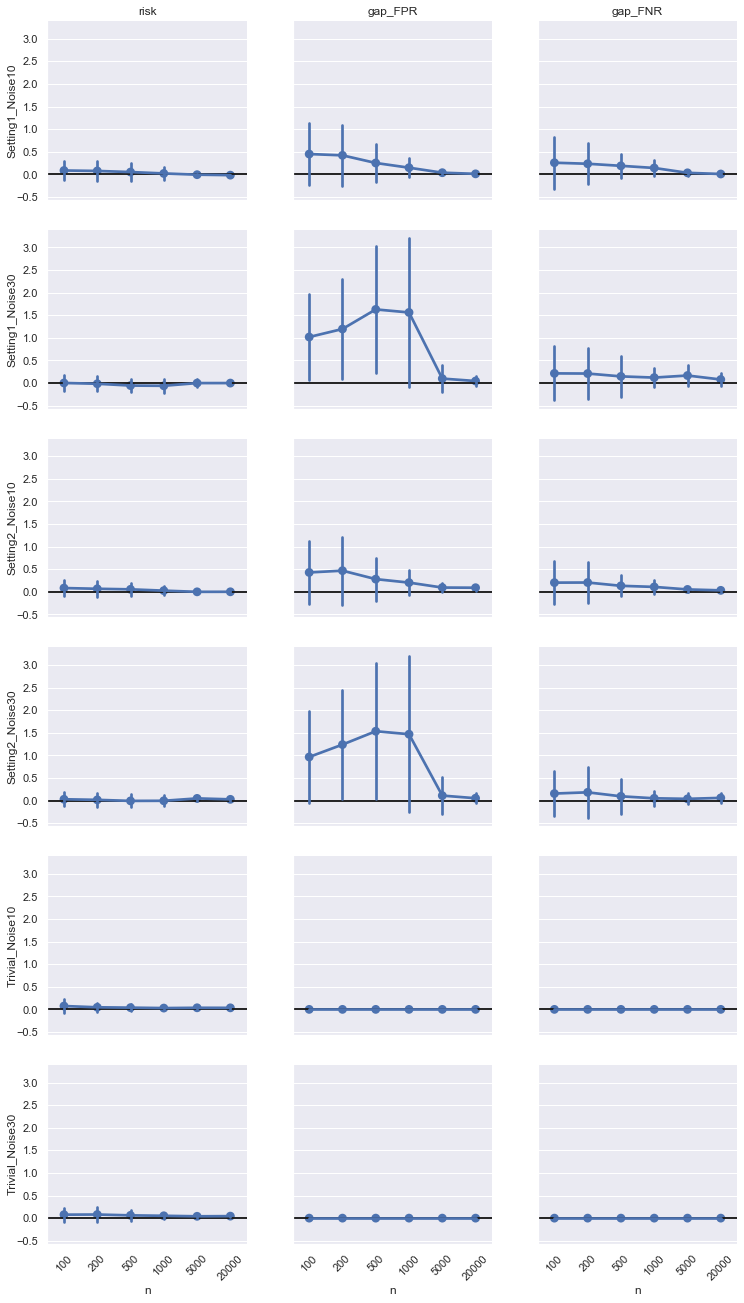

In [113]:
sns.set()
plot_metrics2(metrics_comb_25, n_arr, row='setting', col='metric',
              risk_best=[0]*6, epsilon_pos=[0]*6, epsilon_neg=[0]*6,
              aspect=1.2)

### Scaled by $\sqrt{n}$

In [73]:
metrics_comb_sqrt = transform_metrics(metrics_comb, risk=(risk_best1, risk_best1,
                                                          risk_best2, risk_best2,
                                                          risk_best3, risk_best3),
                                      risk_change=(risk_change1, risk_change1,
                                                          risk_change2, risk_change2,
                                                          risk_change3, risk_change3),
                                      epsilon_pos=(0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
                                      epsilon_neg=(0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
                                      scale=0.5)

In [76]:
metrics_comb_sqrt.to_csv('../out/task1/metrics_comb_sqrt.csv', index = False)

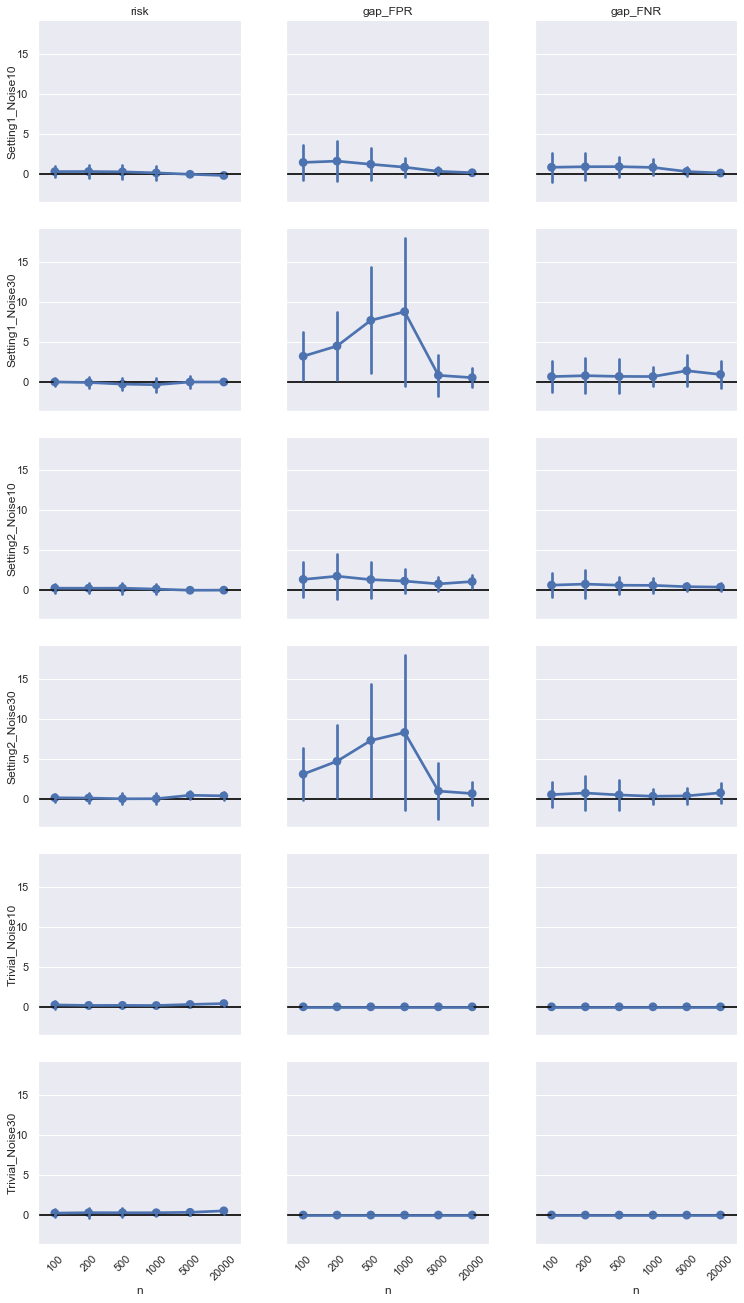

In [75]:
sns.set()
plot_metrics2(metrics_comb_sqrt, n_arr, row='setting', col='metric',
              risk_best=[0]*6, epsilon_pos=[0]*6, epsilon_neg=[0]*6,
              aspect=1.2)

### Scaled by $n^{0.75}$

In [77]:
metrics_comb_75 = transform_metrics(metrics_comb, risk=(risk_best1, risk_best1,
                                                        risk_best2, risk_best2,
                                                        risk_best3, risk_best3),
                                      risk_change=(risk_change1, risk_change1,
                                                          risk_change2, risk_change2,
                                                          risk_change3, risk_change3),                                    
                                    epsilon_pos=(0.05, 0.05, 0.10,
                                                 0.10, 1.0, 1.0),
                                    epsilon_neg=(0.05, 0.05, 0.20,
                                                 0.20, 1.0, 1.0), scale=0.75)

In [78]:
metrics_comb_75.to_csv('../out/task1/metrics_comb_75.csv', index = False)

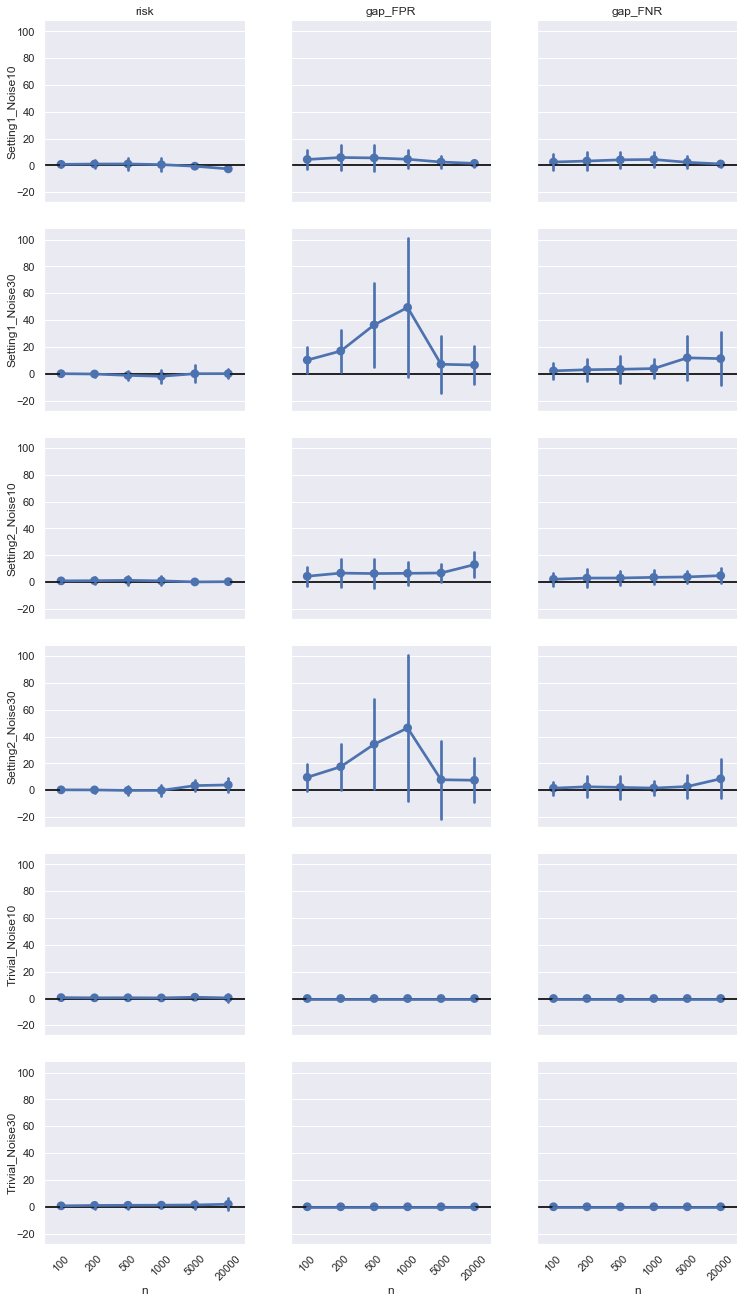

In [380]:
sns.set()
plot_metrics2(metrics_comb_75, n_arr, row = 'setting', col = 'metric',
              risk_best = [0]*6, epsilon_pos = [0]*6, epsilon_neg = [0]*6,
              aspect = 1.2)

### Scaled by $n$

In [79]:
metrics_comb_100 = transform_metrics(metrics_comb, risk = (risk_best1, risk_best1, risk_best2, risk_best2,
                          risk_best3, risk_best3),
                                      risk_change=(risk_change1, risk_change1,
                                                          risk_change2, risk_change2,
                                                          risk_change3, risk_change3),                                      
                         epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0), scale = 1.0)

In [80]:
metrics_comb_100.to_csv('../out/task1/metrics_comb_100.csv', index = False)

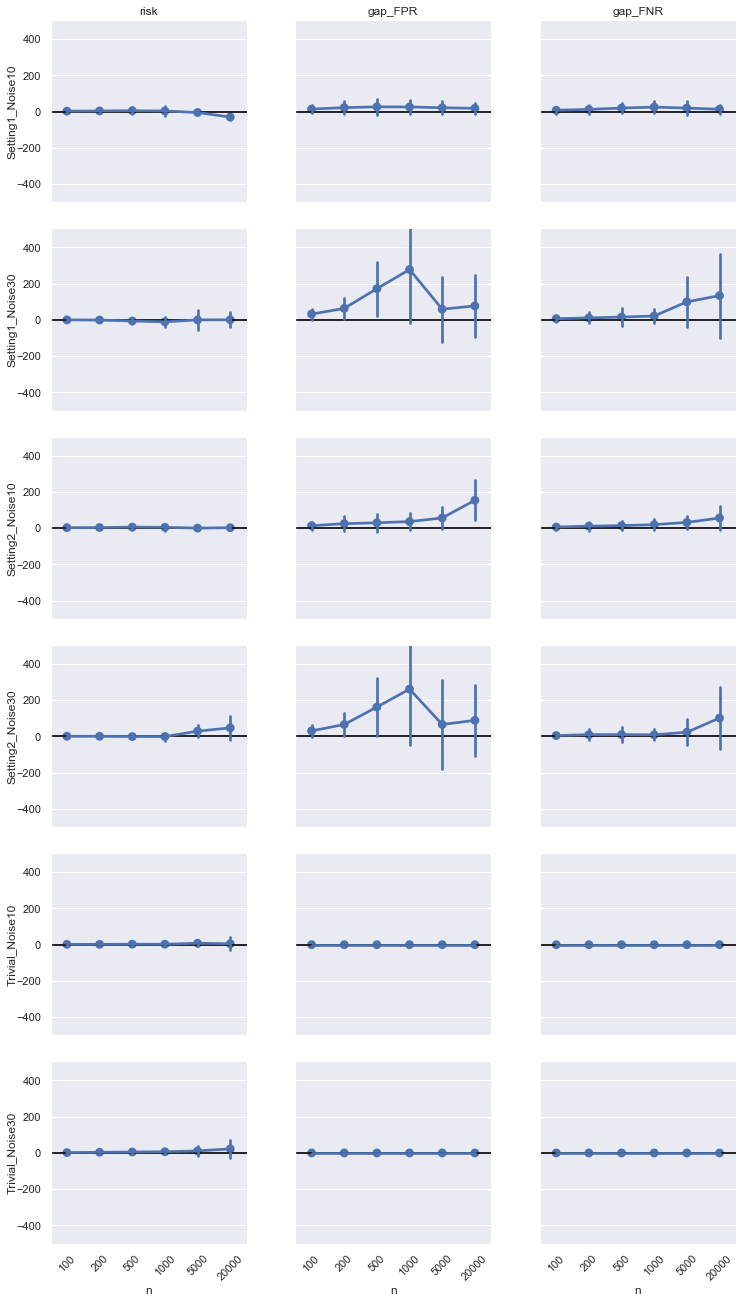

In [378]:
sns.set()
plot_metrics2(metrics_comb_100, n_arr, row = 'setting', col = 'metric',
              risk_best = [0]*6, epsilon_pos = [0]*6, epsilon_neg = [0]*6,              
              aspect = 1.2, ylim = (-500, 500))

## Get estimated fair predictors: plugin

### Setting 1: equal epsilon values

In [384]:
noise_coef = 10
res1_10_sr = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.05,
                   epsilon_neg = 0.05, outcome = 'muhat0') for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [406]:
noise_coef = 30
res1_30_sr = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.05,
                   epsilon_neg = 0.05, outcome = 'muhat0') for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [407]:
with open('../out/task1/res1_10_sr.pickle', 'wb') as file_out:
    pickle.dump(res1_10_sr, file_out)
    
with open('../out/task1/res1_30_sr.pickle', 'wb') as file_out:
    pickle.dump(res1_30_sr, file_out)

In [386]:
metrics1_10_sr = metrics_to_df(res1_10_sr, n_arr, 'Setting1_Noise10', data_val, ci=None)

In [408]:
metrics1_30_sr = metrics_to_df(res1_30_sr, n_arr, 'Setting1_Noise30', data_val, ci=None)

In [409]:
metrics1_10_sr.to_csv('../out/task1/metrics1_10_sr.csv', index = False)
metrics1_30_sr.to_csv('../out/task1/metrics1_30_sr.csv', index = False)

### Setting 2: different epsilon values

In [410]:
noise_coef = 10
res2_10_sr = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.10,
                   epsilon_neg = 0.20, outcome = 'muhat0') for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [26]:
noise_coef = 30
res2_30_sr = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.10,
                   epsilon_neg = 0.20, outcome = 'muhat0') for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [27]:
# with open('../out/res2_10_sr.pickle', 'wb') as file_out:
#     pickle.dump(res2_10_sr, file_out)
    
with open('../out/task1/res2_30_sr.pickle', 'wb') as file_out:
    pickle.dump(res2_30_sr, file_out)

In [417]:
metrics2_10_sr = metrics_to_df(res2_10_sr, n_arr, 'Setting2_Noise10', data_val)

In [28]:
metrics2_30_sr = metrics_to_df(res2_30_sr, n_arr, 'Setting2_Noise30', data_val)

In [29]:
# metrics2_10_sr.to_csv('../out/metrics2_10_sr.csv', index = False)
metrics2_30_sr.to_csv('../out/task1/metrics2_30_sr.csv', index = False)

### Setting 3: no fairness constraints

In [421]:
noise_coef = 10
res3_10 = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 1.0,
                   epsilon_neg = 1.0, outcome = 'muhat0') for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [422]:
noise_coef = 30
res3_30 = [sim_theta(nn, mc_reps, noise_coef, data_params, epsilon_pos = 1.0,
                   epsilon_neg = 1.0, outcome = 'muhat0') for nn in n_arr]

Simulating theta-hat for sample size 100
Simulating theta-hat for sample size 200
Simulating theta-hat for sample size 500
Simulating theta-hat for sample size 1000
Simulating theta-hat for sample size 5000
Simulating theta-hat for sample size 20000


In [426]:
with open('../out/task1/res3_10_sr.pickle', 'wb') as file_out:
    pickle.dump(res3_10_sr, file_out)
    
with open('../out/task1/res3_30_sr.pickle', 'wb') as file_out:
    pickle.dump(res3_30_sr, file_out)

In [428]:
metrics3_10_sr = metrics_to_df(res3_10_sr, n_arr, 'Setting3_Noise10', data_val, ci=None)

In [429]:
metrics3_30_sr = metrics_to_df(res3_30_sr, n_arr, 'Setting3_Noise30', data_val, ci=None)

In [441]:
metrics3_10_sr.to_csv('../out/task1/metrics3_10_sr.csv', index = False)
metrics3_30_sr.to_csv('../out/task1/metrics3_30_sr.csv', index = False)

## Plot combined results: plugin

In [102]:
metrics_comb_sr = pd.concat([metrics1_10_sr, metrics1_30_sr, metrics2_10_sr,
                             metrics2_30_sr, metrics3_10_sr, metrics3_30_sr])
metrics_comb_sr = metrics_comb_sr.drop(columns='outcome')

In [103]:
metrics_comb_sr.to_csv('../out/task1/metrics_comb_sr.csv', index = False)

### Unscaled

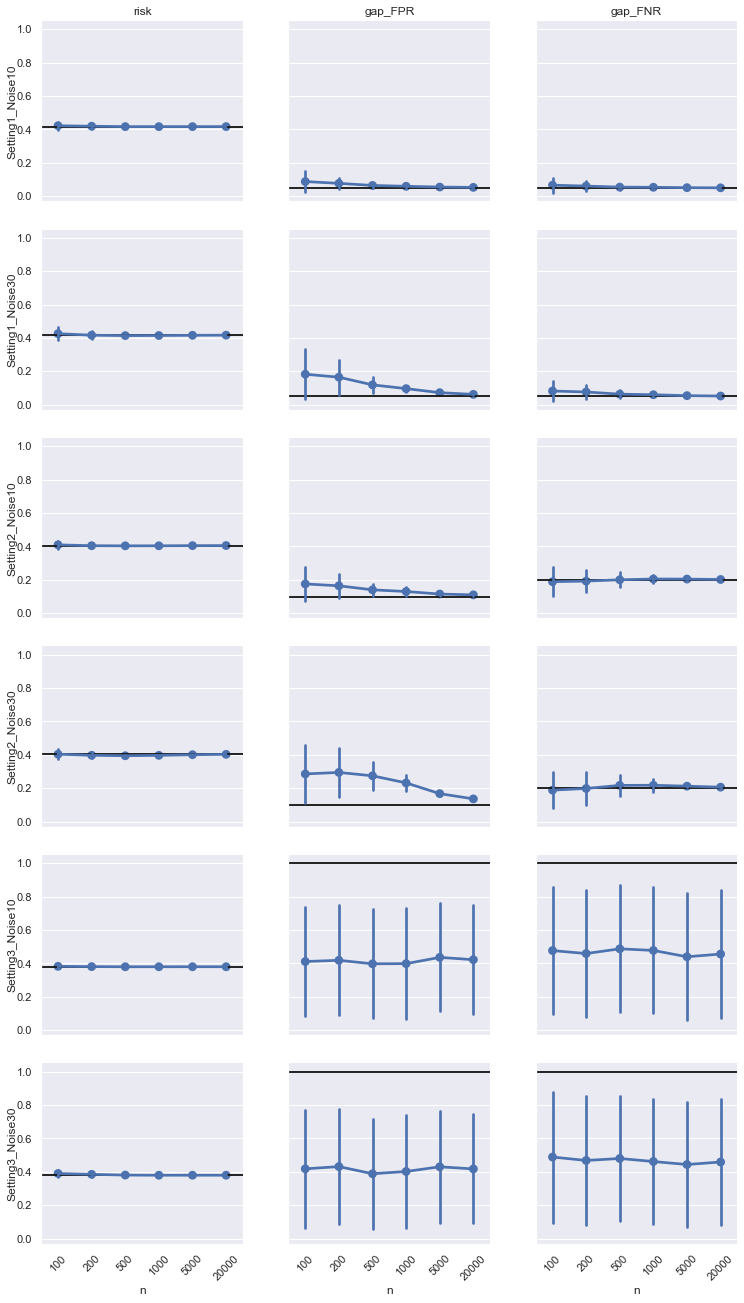

In [115]:
sns.set()
plot_metrics2(metrics_comb_sr, n_arr, row='setting', col='metric',
              risk_best=(risk_best1, risk_best1, risk_best2,
                         risk_best2, risk_best3, risk_best3),
              epsilon_pos=(0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg=(0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
              aspect=1.2)

### Scaled by $n^{0.25}$

In [105]:
metrics_comb_sr_25 = transform_metrics(metrics_comb_sr,
              risk = (risk_best1, risk_best1, risk_best2, risk_best2, risk_best3, risk_best3),
                                      risk_change=(risk_change1, risk_change1,
                                                          risk_change2, risk_change2,
                                                          risk_change3, risk_change3),                                       
              epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
                                      scale=0.25)

In [106]:
metrics_comb_sr_25.to_csv('../out/task1/metrics_comb_sr_25.csv', index = False)

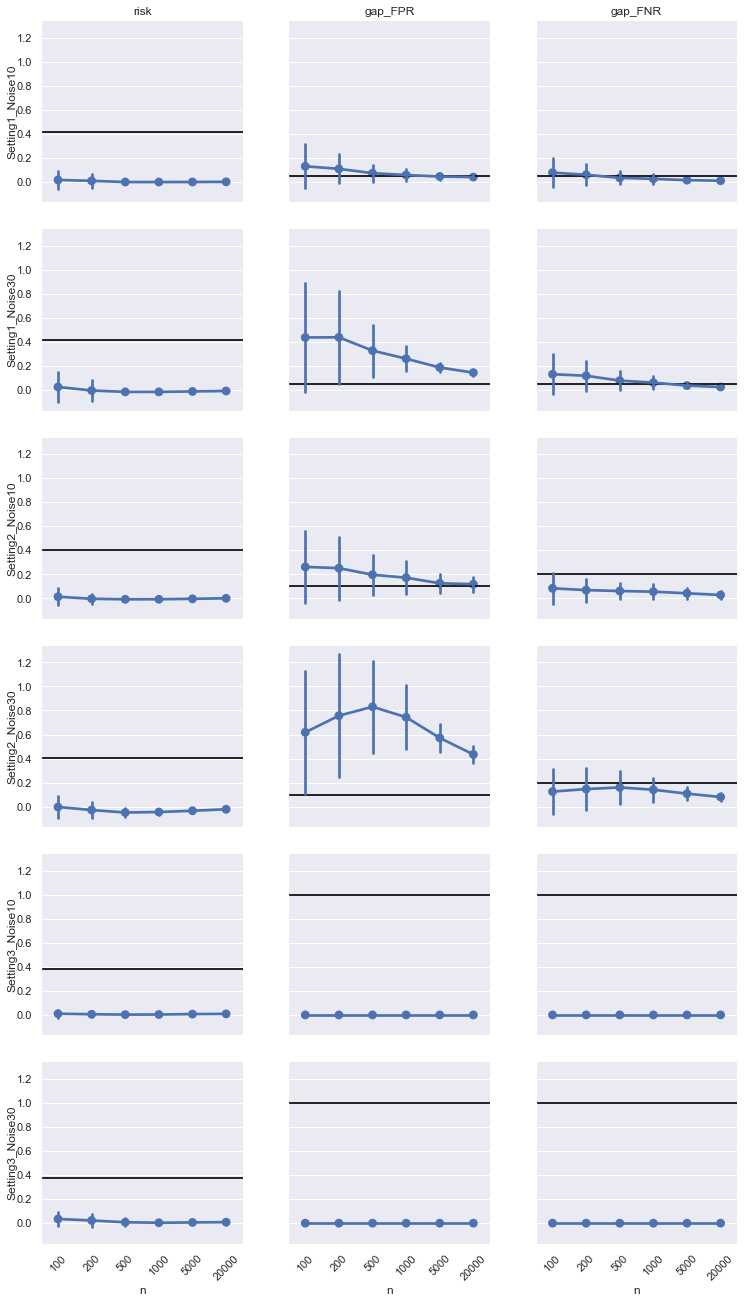

In [116]:
sns.set()
plot_metrics2(metrics_comb_sr_25, n_arr, row = 'setting', col = 'metric',
              risk_best = (risk_best1, risk_best1, risk_best2, risk_best2, risk_best3, risk_best3),
              epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
              aspect = 1.2)

### Scaled by $\sqrt{n}$

In [107]:
metrics_comb_sr_sqrt = transform_metrics(metrics_comb_sr,
              risk = (risk_best1, risk_best1, risk_best2, risk_best2, risk_best3, risk_best3),
                                      risk_change=(risk_change1, risk_change1,
                                                          risk_change2, risk_change2,
                                                          risk_change3, risk_change3),                                         
              epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
                                      scale=0.5)

In [108]:
metrics_comb_sr_sqrt.to_csv('../out/task1/metrics_comb_sr_sqrt.csv', index = False)

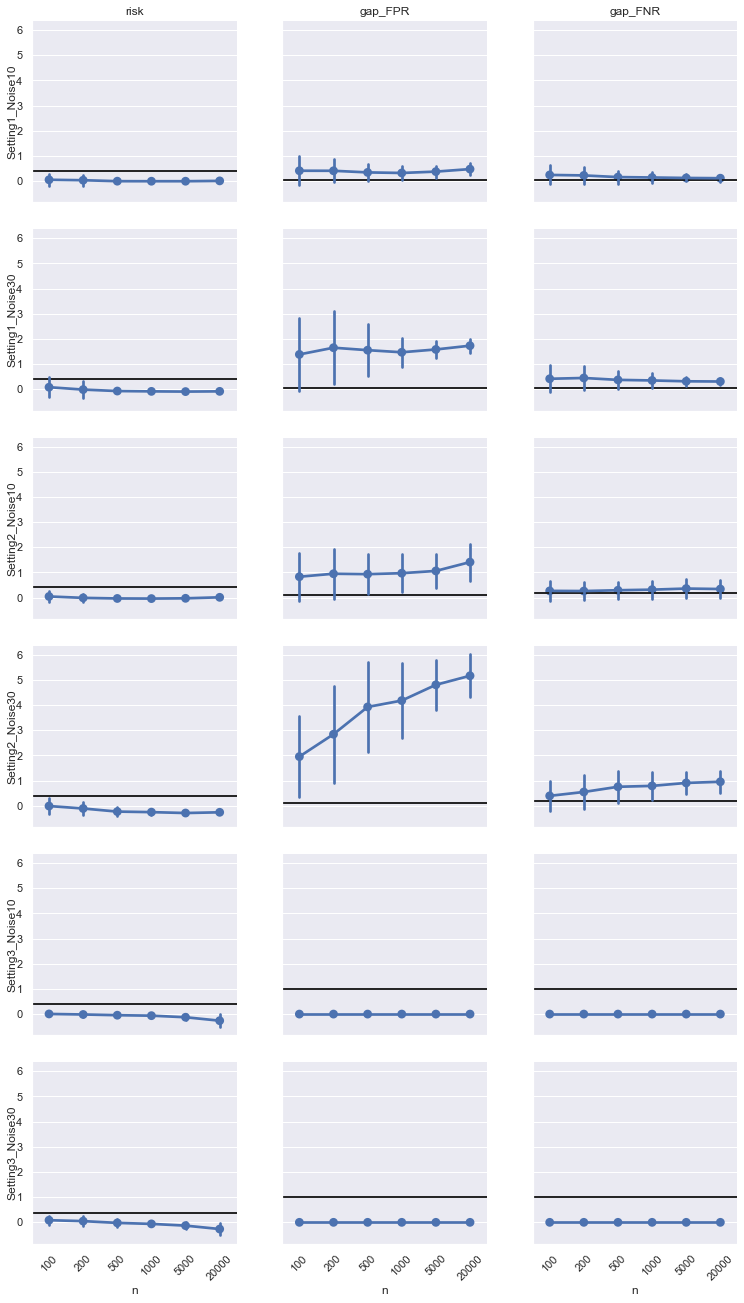

In [452]:
sns.set()
plot_metrics2(metrics_comb_sr_sqrt, n_arr, row = 'setting', col = 'metric',
              risk_best = (risk_best1, risk_best1, risk_best2, risk_best2, risk_best3, risk_best3),
              epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
              aspect = 1.2)

### Scaled by $n^{0.75}$

In [109]:
metrics_comb_sr_75 = transform_metrics(metrics_comb_sr,
              risk = (risk_best1, risk_best1, risk_best2, risk_best2, risk_best3, risk_best3),
                                      risk_change=(risk_change1, risk_change1,
                                                          risk_change2, risk_change2,
                                                          risk_change3, risk_change3),                                          
              epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
                                      scale=0.75)

In [110]:
metrics_comb_sr_75.to_csv('../out/task1/metrics_comb_sr_75.csv', index = False)

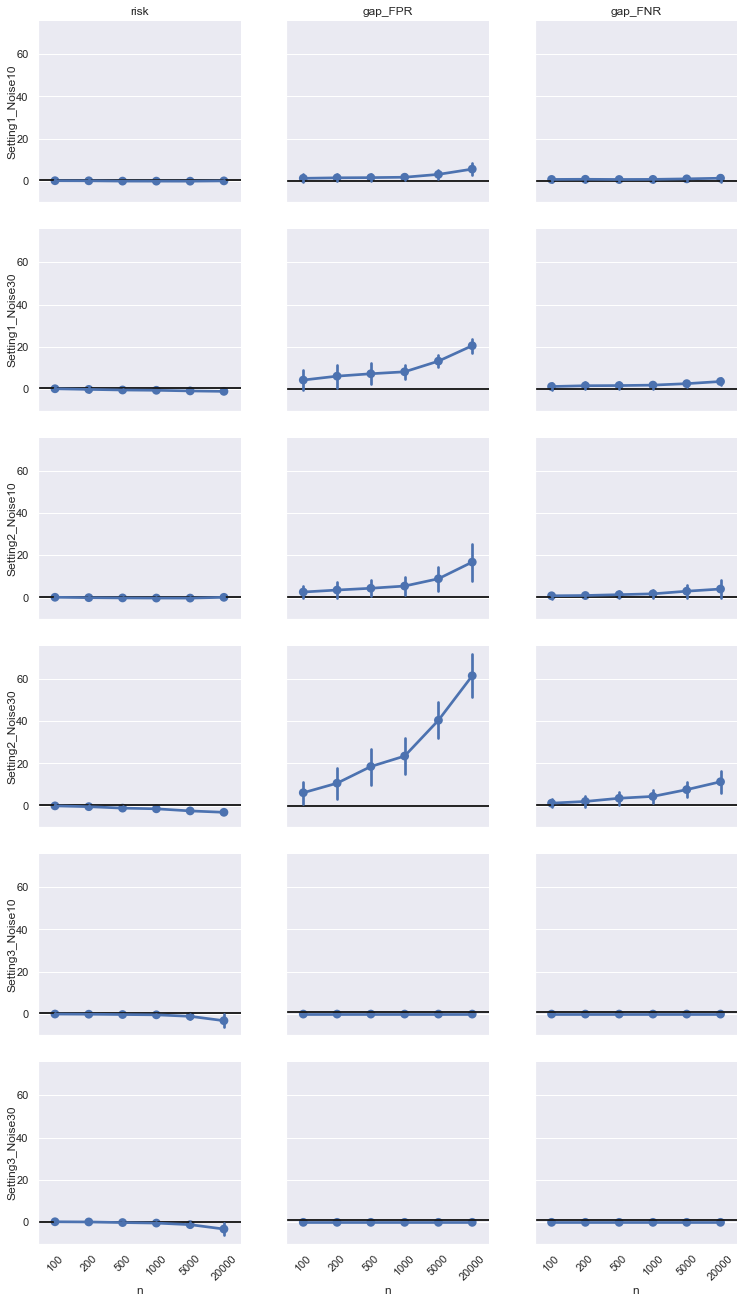

In [451]:
sns.set()
plot_metrics2(metrics_comb_sr_75, n_arr, row = 'setting', col = 'metric',
              risk_best = (risk_best1, risk_best1, risk_best2, risk_best2, risk_best3, risk_best3),
              epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
              aspect = 1.2)

### Scaled by $n$

In [111]:
metrics_comb_sr_100 = transform_metrics(metrics_comb_sr,
              risk = (risk_best1, risk_best1, risk_best2, risk_best2, risk_best3, risk_best3),
                                      risk_change=(risk_change1, risk_change1,
                                                          risk_change2, risk_change2,
                                                          risk_change3, risk_change3),                                         
              epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
                                      scale=1.0)

In [112]:
metrics_comb_sr_100.to_csv('../out/task1/metrics_comb_sr_100.csv', index = False)

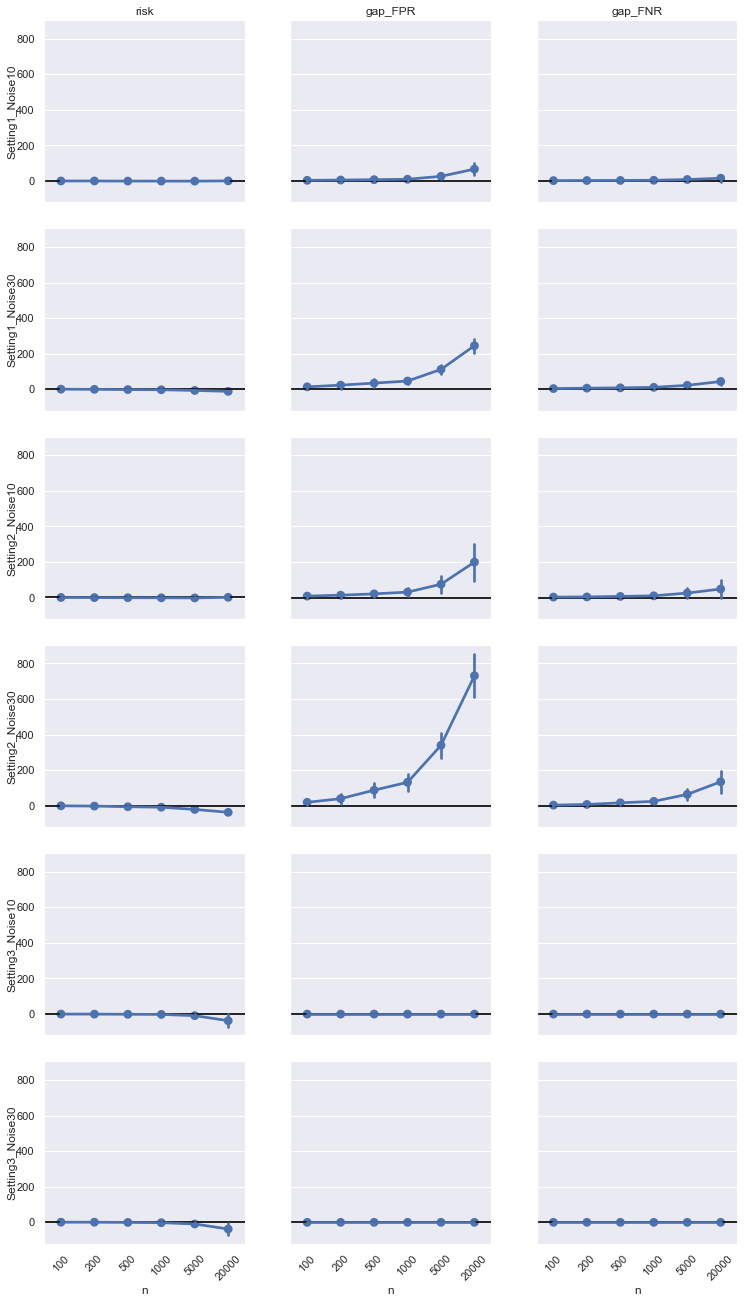

In [457]:
sns.set()
plot_metrics2(metrics_comb_sr_100, n_arr, row = 'setting', col = 'metric',
              risk_best = (risk_best1, risk_best1, risk_best2, risk_best2, risk_best3, risk_best3),
              epsilon_pos = (0.05, 0.05, 0.10, 0.10, 1.0, 1.0),
              epsilon_neg = (0.05, 0.05, 0.20, 0.20, 1.0, 1.0),
              aspect = 1.2)

# Task (2) Simulations

## Read in previous results

In [86]:
## Read in previous results
data_val = pd.read_csv('../out/data_val.csv')

metrics_est1 = pd.read_csv('../out/task2/metrics_est1.csv')
metrics_est2 = pd.read_csv('../out/task2/metrics_est2.csv')
metrics_est1_sr = pd.read_csv('../out/task2/metrics_est1_sr.csv')
metrics_est2_sr = pd.read_csv('../out/task2/metrics_est2_sr.csv')

metrics_post1 = pd.read_csv('../out/task2/metrics_post1.csv')
metrics_post2 = pd.read_csv('../out/task2/metrics_post2.csv')

In [8]:
## Metrics for the input predictor, for potential plotting purposes
metrics_pre = metrics([0, 1, 0, 1], data_val, outcome = 'mu0', ci=0.95)
risk_pre = metrics_pre.query("metric=='risk'")['value'].values[0]

## Simulations setup

In [209]:
theta1 = [0.64, 0.39, 0.53, 0.46]           # Scenario 1
# theta2 = [0.74, 0.97, 0.05, 0.77]           # Scenario 2
theta2 = [0.74, 1.0, 0, 0.8]           # Scenario 2
n_arr = [100, 200, 500, 1000, 5000, 20000]  # Sample sizes
mc_reps = 500                               # Monte Carlo iterations

In [210]:
metrics_post1 = metrics(theta1, data_val, outcome = 'mu0')
metrics_post2 = metrics(theta2, data_val, outcome = 'mu0')

In [211]:
metrics_post1.to_csv('../out/task2/metrics_post1.csv', index = False)
metrics_post2.to_csv('../out/task2/metrics_post2.csv', index = False)

In [212]:
risk_post1 = metrics_post1.loc[metrics_post1['metric'] == 'risk', 'value'].values[0]
risk_change_post1 = metrics_post1.loc[metrics_post1['metric'] == 'risk_change', 'value'].values[0]
gap_FPR_post1 = metrics_post1.loc[metrics_post1['metric'] == 'gap_FPR', 'value'].values[0]
gap_FNR_post1 = metrics_post1.loc[metrics_post1['metric'] == 'gap_FNR', 'value'].values[0]

risk_post2 = metrics_post2.loc[metrics_post2['metric'] == 'risk', 'value'].values[0]
risk_change_post2 = metrics_post2.loc[metrics_post2['metric'] == 'risk_change', 'value'].values[0]
gap_FPR_post2 = metrics_post2.loc[metrics_post2['metric'] == 'gap_FPR', 'value'].values[0]
gap_FNR_post2 = metrics_post2.loc[metrics_post2['metric'] == 'gap_FNR', 'value'].values[0]

## Scenario 1: doubly robust

In [185]:
# metrics_est1_10 = sim_task2(theta1, 10, n_arr, mc_reps, data_params, outcome = 'phihat')
metrics_est1_30 = sim_task2(theta1, 30, n_arr, mc_reps, data_params,
                            outcome = 'phihat', ci_scale = 'logit')
# metrics_est1_30 = sim_task2(theta1, 30, n_arr, mc_reps, data_params,
#                             outcome = 'phihat', ci_scale = 'expit')

# metrics_est1_30.to_csv('../out/metrics_est1_expit.csv', index = False)
metrics_est1_30.to_csv('../out/task2/metrics_est1_logit.csv', index = False)

Estimating metrics for sample size 100: 500 reps
Estimating metrics for sample size 200: 500 reps
Estimating metrics for sample size 500: 500 reps
Estimating metrics for sample size 1000: 500 reps
Estimating metrics for sample size 5000: 500 reps
Estimating metrics for sample size 20000: 500 reps


In [528]:
metrics_est1 = pd.concat([metrics_est1_10, metrics_est1_30],
                     keys = ['theta1_noise10', 'theta1_noise30'],
                    names = ['scenario', 'dummy'])

metrics_est1 = metrics_est1.reset_index().drop(columns = 'dummy')

### Get CI coverage

In [186]:
cov_means1_30 = coverage(metrics_est1_30, metrics_post1)
cov_means1_30.to_csv('../out/task2/task2_scenario1_coverage_logit.csv', index = False)
cov_means1_30

n,metric,100,200,500,1000,5000,20000
0,FNR0,0.990,0.990,0.982,0.988,0.922,0.934
1,FNR1,0.986,0.990,0.990,0.996,0.978,0.710
2,FPR0,0.994,0.984,0.982,0.958,0.938,0.950
3,FPR1,0.902,0.886,0.928,0.948,0.956,0.572
4,gap_FNR,0.992,0.996,0.986,0.992,0.940,0.942
5,gap_FPR,0.976,0.982,0.972,0.988,0.970,0.916
6,risk,0.984,0.918,0.868,0.844,0.838,0.854
7,risk_change,1.000,0.986,0.928,0.942,0.706,0.778


In [187]:
np.median(cov_means1_30.drop(columns='metric').values.flatten())

0.964

In [ ]:
with open('../out/task2/cov_means1_30.tex', 'w') as file_out:
    file_out.write(cov_means1_30.set_index('metric').to_latex(index = True, index_names = False,
                                          float_format = '%0.2f'))

## Scenario 2: doubly robust

In [213]:
# metrics_est2_10 = sim_task2(theta2, 10, n_arr, mc_reps, data_params, outcome = 'phihat')
metrics_est2_30 = sim_task2(theta2, 30, n_arr, mc_reps, data_params,
                            outcome = 'phihat', ci_scale = 'logit')

metrics_est2_30.to_csv('../out/task2/metrics_est2_30_logit.csv', index = False)

Estimating metrics for sample size 100: 500 reps
Estimating metrics for sample size 200: 500 reps
Estimating metrics for sample size 500: 500 reps
Estimating metrics for sample size 1000: 500 reps
Estimating metrics for sample size 5000: 500 reps
Estimating metrics for sample size 20000: 500 reps


In [54]:
metrics_est2 = pd.concat([metrics_est2_10, metrics_est2_30],
                     keys = ['theta2_noise10', 'theta2_noise30'],
                    names = ['scenario', 'dummy'])

metrics_est2 = metrics_est2.reset_index().drop(columns = 'dummy')

metrics_est2.to_csv('../out/task2/metrics_est2.csv', index = False)

NameError: name 'metrics_est2_10' is not defined

### Get CI coverage

In [214]:
cov_means2_30 = coverage(metrics_est2_30, metrics_post2)
cov_means2_30.to_csv('../out/task2/task2_scenario2_coverage_logit.csv', index = False)
cov_means2_30

n,metric,100,200,500,1000,5000,20000
0,FNR0,0.922,0.940,0.960,0.978,0.986,1.000
1,FNR1,0.914,0.948,0.986,0.996,0.996,0.934
2,FPR0,0.846,0.878,0.872,0.876,0.932,0.930
3,FPR1,0.666,0.804,0.922,0.952,0.998,0.958
4,gap_FNR,0.984,0.984,0.992,0.998,0.994,0.974
5,gap_FPR,0.646,0.788,0.856,0.922,1.000,0.920
6,risk,1.000,1.000,0.890,0.908,0.612,0.736
7,risk_change,0.996,0.988,0.988,0.958,0.942,0.946


In [215]:
np.median(cov_means2_30.drop(columns='metric').values.flatten())

0.947

In [258]:
with open('../out/task2/cov_means2_30.tex', 'w') as file_out:
    file_out.write(cov_means1_30.set_index('metric').to_latex(index = True, index_names = False,
                                          float_format = '%0.2f'))

## Plot results: doubly robust

### Unscaled

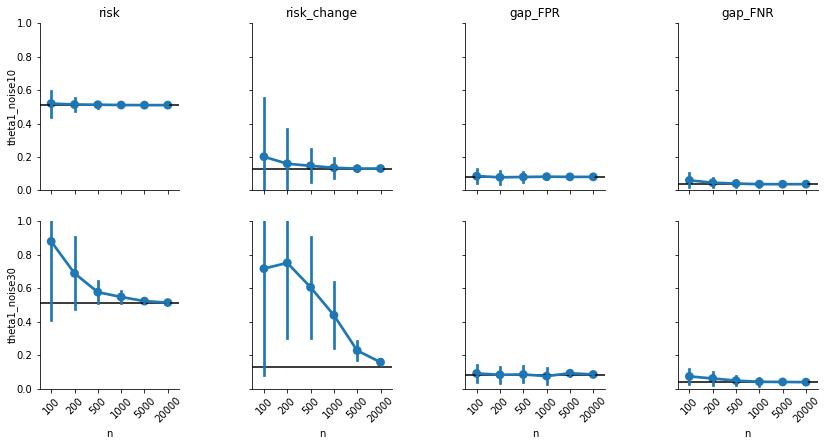

In [583]:
## Scenario 1
plot_metrics_est(metrics_est1, metrics_pre, metrics_post1, n_arr, row = 'setting')

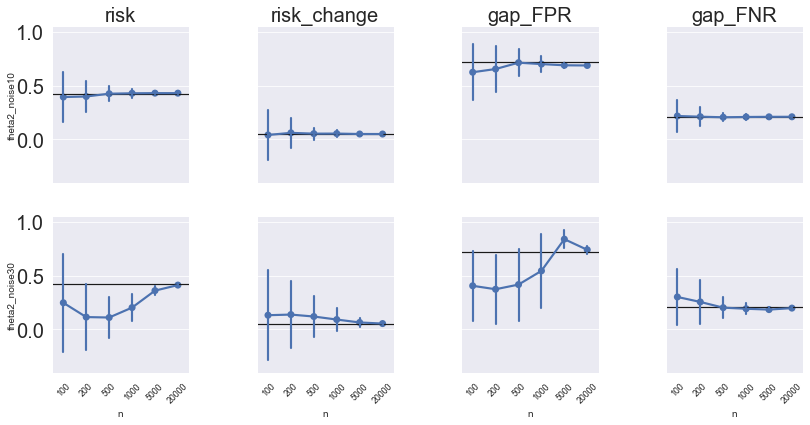

In [852]:
## Scenario 2
plot_metrics_est(metrics_est2, metrics_pre, metrics_post2, n_arr, row = 'scenario')

### Scaled by $n^{0.25}$

In [653]:
metrics_est1_25 = transform_metrics(metrics_est1,
              risk = (risk_post1, risk_post1),
              risk_change = (risk_change_post1, risk_change_post1),
              epsilon_pos = (gap_FPR_post1, gap_FPR_post1),
              epsilon_neg = (gap_FNR_post1, gap_FNR_post1),
                                      scale=0.25)

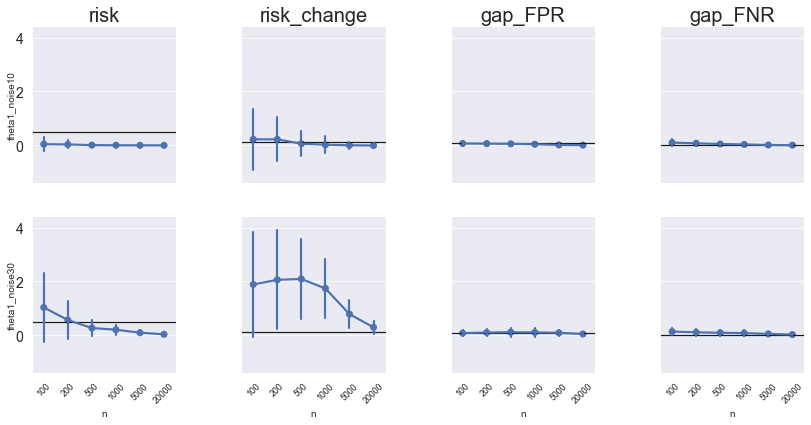

In [655]:
plot_metrics_est(metrics_est1_25, metrics_pre, metrics_post1, n_arr, row = 'scenario')

In [656]:
metrics_est2_25 = transform_metrics(metrics_est2,
              risk = (risk_post2, risk_post2),
              risk_change = (risk_change_post2, risk_change_post2),
              epsilon_pos = (gap_FPR_post2, gap_FPR_post2),
              epsilon_neg = (gap_FNR_post2, gap_FNR_post2),
                                      scale=0.25)

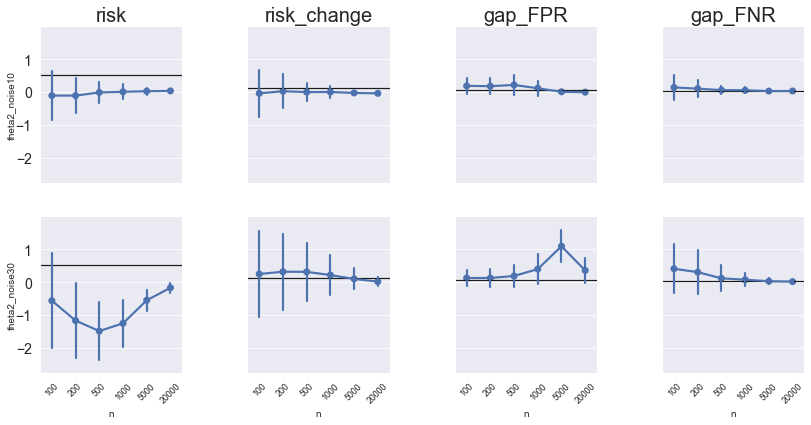

In [657]:
plot_metrics_est(metrics_est2_25, metrics_pre, metrics_post1, n_arr, row = 'scenario')

### Scaled by $\sqrt{n}$

In [545]:
metrics_est1_sqrt = transform_metrics(metrics_est1,
              risk = (risk_post1, risk_post1),
              risk_change = (risk_change_post1, risk_change_post1),
              epsilon_pos = (gap_FPR_post1, gap_FPR_post1),
              epsilon_neg = (gap_FNR_post1, gap_FNR_post1),
                                      scale=0.5)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


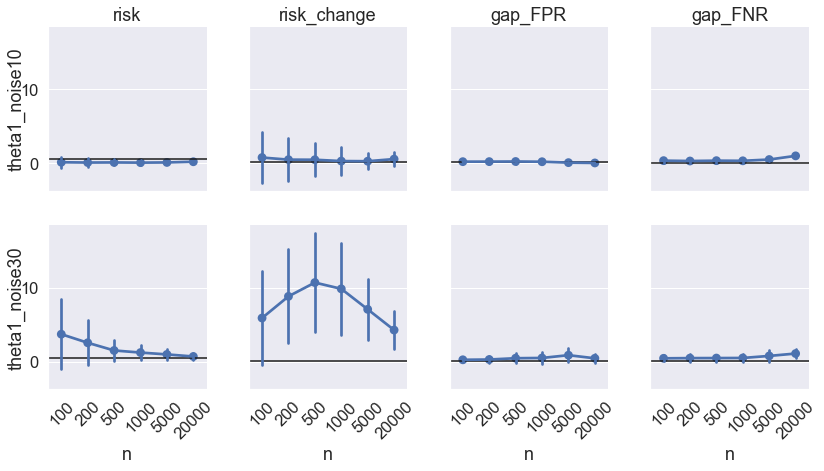

In [546]:
plot_metrics_est(metrics_est1_sqrt, metrics_pre, metrics_post1, n_arr, row = 'setting')

In [ ]:
metrics_est2_sqrt = transform_metrics(metrics_est2,
              risk = (risk_post2, risk_post2),
              risk_change = (risk_change_post2, risk_change_post2),
              epsilon_pos = (gap_FPR_post2, gap_FPR_post2),
              epsilon_neg = (gap_FNR_post2, gap_FNR_post2),
                                      scale=0.5)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


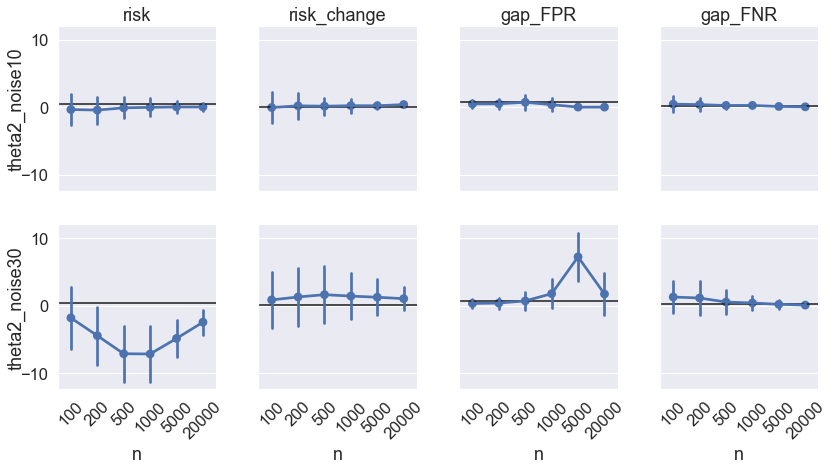

In [548]:
plot_metrics_est(metrics_est2_sqrt, metrics_pre, metrics_post2, n_arr, row = 'setting')

### Scaled by $n^{0.75}$

In [549]:
metrics_est1_75 = transform_metrics(metrics_est1,
              risk = (risk_post1, risk_post1),
              risk_change = (risk_change_post1, risk_change_post1),
              epsilon_pos = (gap_FPR_post1, gap_FPR_post1),
              epsilon_neg = (gap_FNR_post1, gap_FNR_post1),
                                      scale=0.75)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


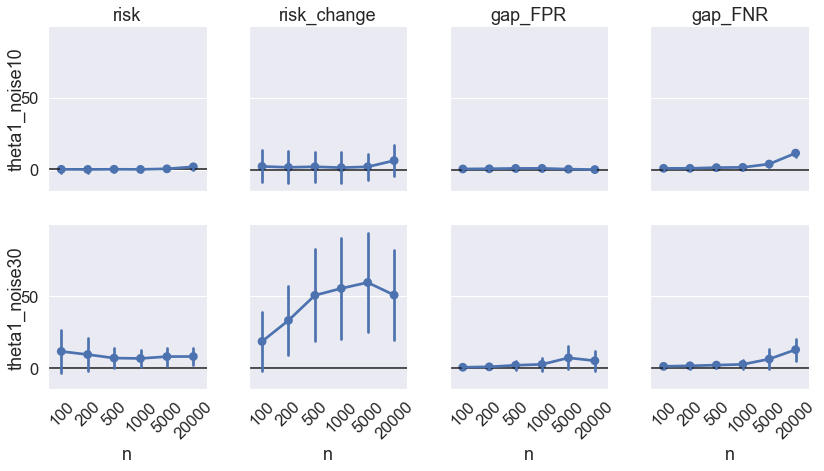

In [550]:
plot_metrics_est(metrics_est1_75, metrics_pre, metrics_post1, n_arr, row = 'setting')

### Scaled by $n$

In [596]:
metrics_est1_100 = transform_metrics(metrics_est1,
              risk = (risk_post1, risk_post1),
              risk_change = (risk_change_post1, risk_change_post1),
              epsilon_pos = (gap_FPR_post1, gap_FPR_post1),
              epsilon_neg = (gap_FNR_post1, gap_FNR_post1),
                                      scale=1.0)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


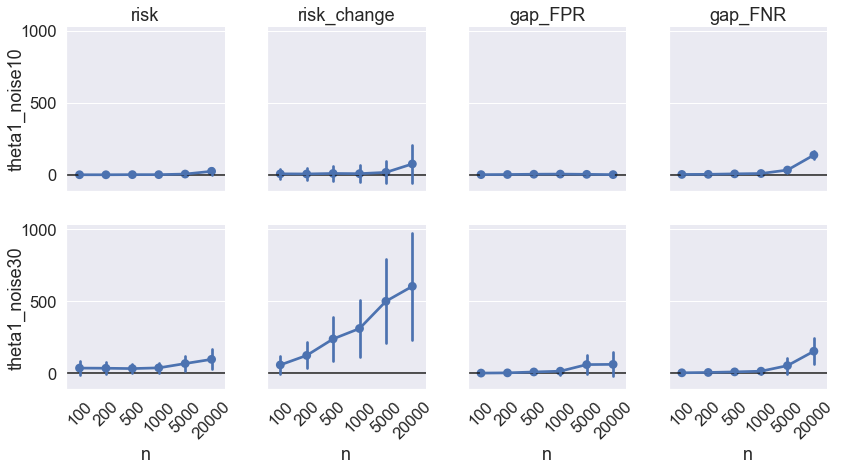

In [597]:
plot_metrics_est(metrics_est1_100, metrics_pre, metrics_post1, n_arr, row = 'setting')

## Scenario 1: plugin

In [603]:
metrics_est1_10_sr = sim_task2(theta1, 10, n_arr, mc_reps, data_params, outcome = 'muhat0')
metrics_est1_30_sr = sim_task2(theta1, 30, n_arr, mc_reps, data_params, outcome = 'muhat0')

Estimating metrics for sample size 100, 500 reps
Estimating metrics for sample size 200, 500 reps
Estimating metrics for sample size 500, 500 reps
Estimating metrics for sample size 1000, 500 reps
Estimating metrics for sample size 5000, 500 reps
Estimating metrics for sample size 20000, 500 reps
Estimating metrics for sample size 100, 500 reps
Estimating metrics for sample size 200, 500 reps
Estimating metrics for sample size 500, 500 reps
Estimating metrics for sample size 1000, 500 reps
Estimating metrics for sample size 5000, 500 reps
Estimating metrics for sample size 20000, 500 reps


In [607]:
metrics_est1_sr = pd.concat([metrics_est1_10_sr, metrics_est1_30_sr],
                     keys = ['theta1_noise10', 'theta1_noise30'],
                    names = ['scenario', 'dummy'])

metrics_est1_sr = metrics_est1_sr.reset_index().drop(columns = 'dummy')

In [594]:
metrics_est1_sr.to_csv('../out/metrics_est1_sr.csv', index = False)

## Scenario 2: plugin

In [216]:
# metrics_est2_10_sr = sim_task2(theta2, 10, n_arr, mc_reps, data_params, outcome = 'muhat0')
metrics_est2_30_sr = sim_task2(theta2, 30, n_arr, mc_reps, data_params, outcome = 'muhat0')

Estimating metrics for sample size 100: 500 reps
Estimating metrics for sample size 200: 500 reps
Estimating metrics for sample size 500: 500 reps
Estimating metrics for sample size 1000: 500 reps
Estimating metrics for sample size 5000: 500 reps
Estimating metrics for sample size 20000: 500 reps


In [218]:
metrics_est2_30_sr.to_csv('../out/task2/metrics_est2_30_sr.csv', index = False)

In [612]:
metrics_est2_sr = pd.concat([metrics_est2_10_sr, metrics_est2_30_sr],
                     keys = ['theta2_noise10', 'theta2_noise30'],
                    names = ['scenario', 'dummy'])

metrics_est2_sr = metrics_est2_sr.reset_index().drop(columns = 'dummy')

In [120]:
metrics_est2_sr.to_csv('../out/metrics_est2_sr.csv', index = False)

## Plot results: plugin

### Unscaled

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


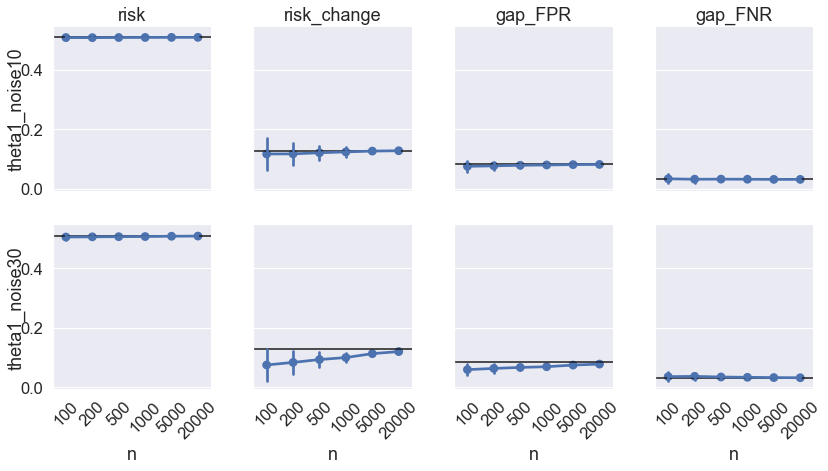

In [615]:
## Scenario 1
plot_metrics_est(metrics_est1_sr, metrics_pre, metrics_post1, n_arr, row = 'setting')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


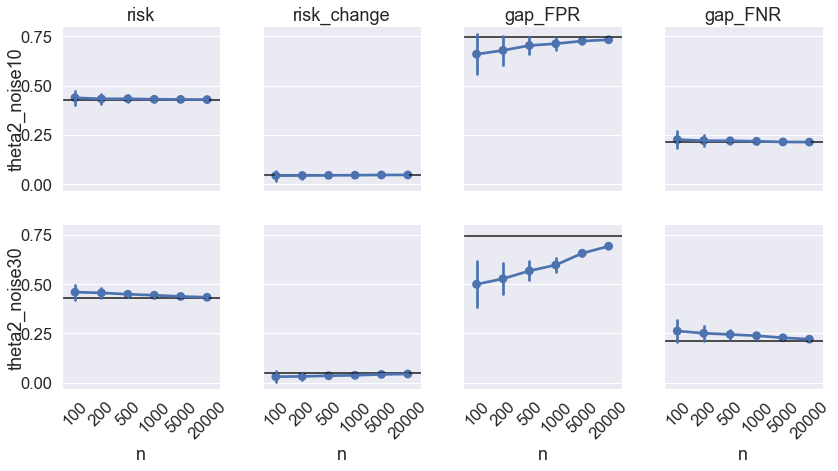

In [619]:
## Scenario 2
plot_metrics_est(metrics_est2_sr, metrics_pre, metrics_post2, n_arr, row = 'setting')

### Scaled by $n^{1/4}$

In [652]:
## Scenario 1
metrics_est1_sr_25 = transform_metrics(metrics_est1_sr,
              risk = (risk_post1, risk_post1),
              risk_change = (risk_change_post1, risk_change_post1),
              epsilon_pos = (gap_FPR_post1, gap_FPR_post1),
              epsilon_neg = (gap_FNR_post1, gap_FNR_post1),
                                      scale=0.25)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


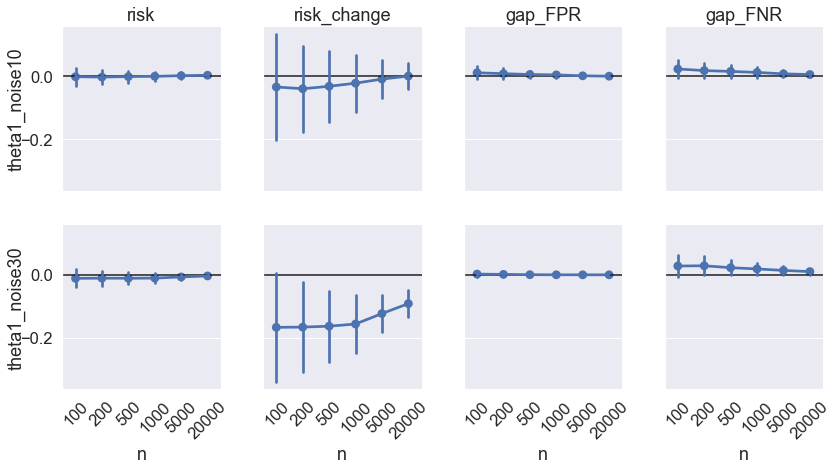

In [634]:
plot_metrics_est(metrics_est1_sr_25, metrics_pre, metrics_centered, n_arr, row = 'setting')

In [659]:
## Scenario 2
metrics_est2_sr_25 = transform_metrics(metrics_est2_sr,
              risk = (risk_post2, risk_post2),
              risk_change = (risk_change_post2, risk_change_post2),
              epsilon_pos = (gap_FPR_post2, gap_FPR_post2),
              epsilon_neg = (gap_FNR_post2, gap_FNR_post2),
                                      scale=0.25)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


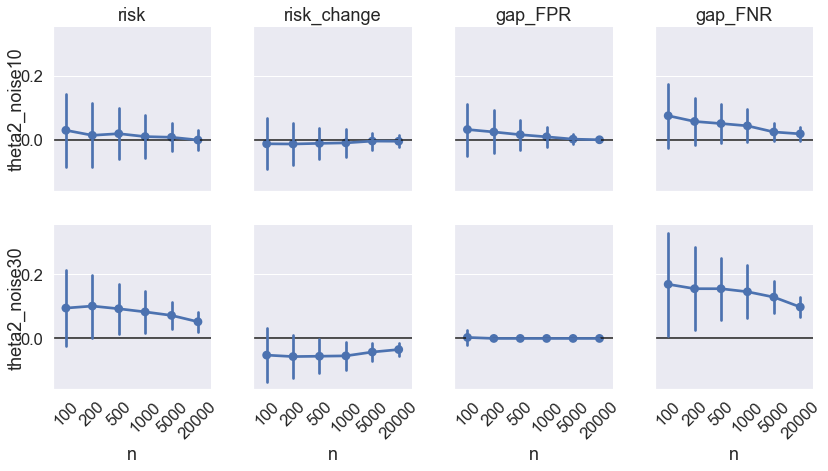

In [636]:
plot_metrics_est(metrics_est2_sr_25, metrics_pre, metrics_centered, n_arr, row = 'setting')

### Scaled by $\sqrt{n}$

In [616]:
## Scenario 1
metrics_est1_sr_sqrt = transform_metrics(metrics_est1_sr,
              risk = (risk_post1, risk_post1),
              risk_change = (risk_change_post1, risk_change_post1),
              epsilon_pos = (gap_FPR_post1, gap_FPR_post1),
              epsilon_neg = (gap_FNR_post1, gap_FNR_post1),
                                      scale=0.5)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


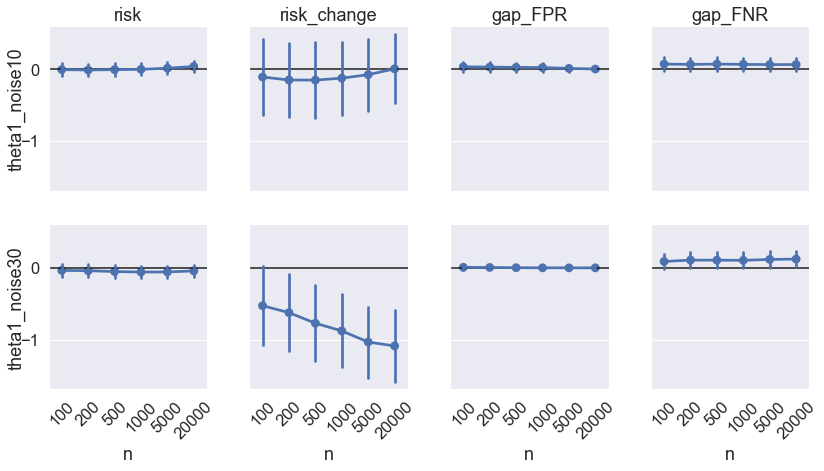

In [655]:
plot_metrics_est(metrics_est1_sr_sqrt, metrics_pre, metrics_centered, n_arr,
                 row = 'setting')

In [114]:
## Scenario 2
metrics_est2_sr_sqrt = transform_metrics(metrics_est2_sr,
              risk = (risk_post2, risk_post2),
              risk_change = (risk_change_post2, risk_change_post2),
              epsilon_pos = (gap_FPR_post2, gap_FPR_post2),
              epsilon_neg = (gap_FNR_post2, gap_FNR_post2), scale=0.5)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


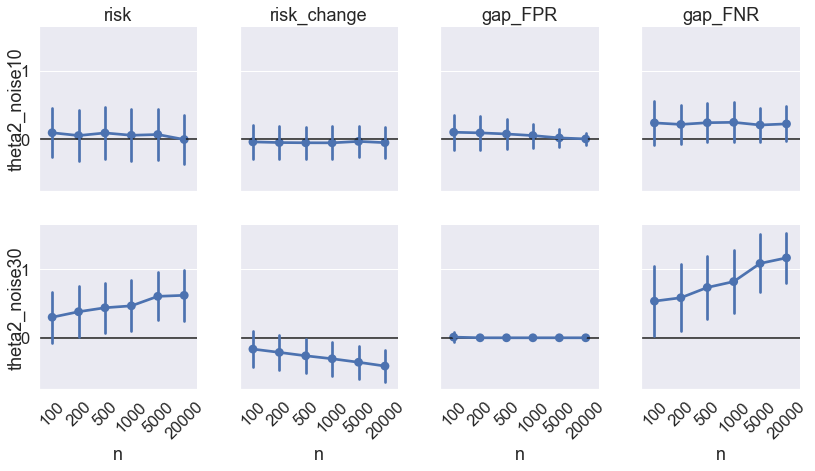

In [657]:
plot_metrics_est(metrics_est2_sr_sqrt, metrics_pre, metrics_centered, n_arr,
                 row = 'setting')

### Scaled by $n^{0.75}$

In [641]:
## Scenario 1
metrics_est1_sr_75 = transform_metrics(metrics_est1_sr,
              risk = (risk_post1, risk_post1),
              risk_change = (risk_change_post1, risk_change_post1),
              epsilon_pos = (gap_FPR_post1, gap_FPR_post1),
              epsilon_neg = (gap_FNR_post1, gap_FNR_post1),
                                      scale=0.75)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


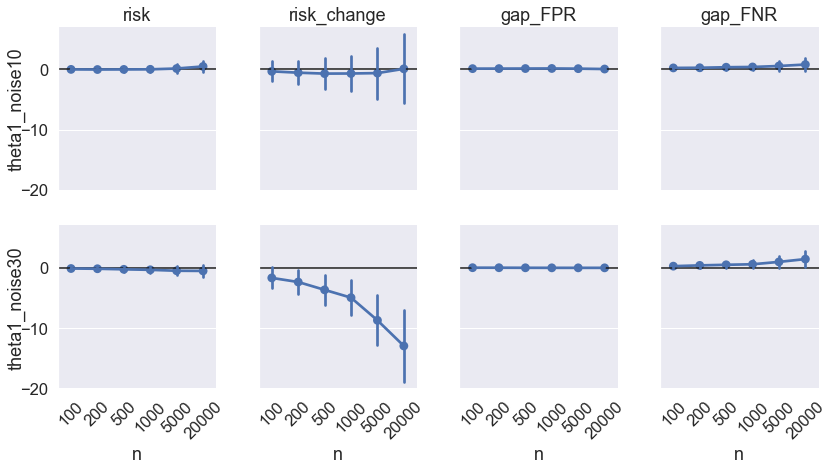

In [642]:
plot_metrics_est(metrics_est1_sr_75, metrics_pre, metrics_centered, n_arr, row = 'setting')

In [643]:
## Scenario 2
metrics_est2_sr_75 = transform_metrics(metrics_est2_sr,
              risk = (risk_post2, risk_post2),
              risk_change = (risk_change_post2, risk_change_post2),
              epsilon_pos = (gap_FPR_post2, gap_FPR_post2),
              epsilon_neg = (gap_FNR_post2, gap_FNR_post2),
                                      scale=0.75)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


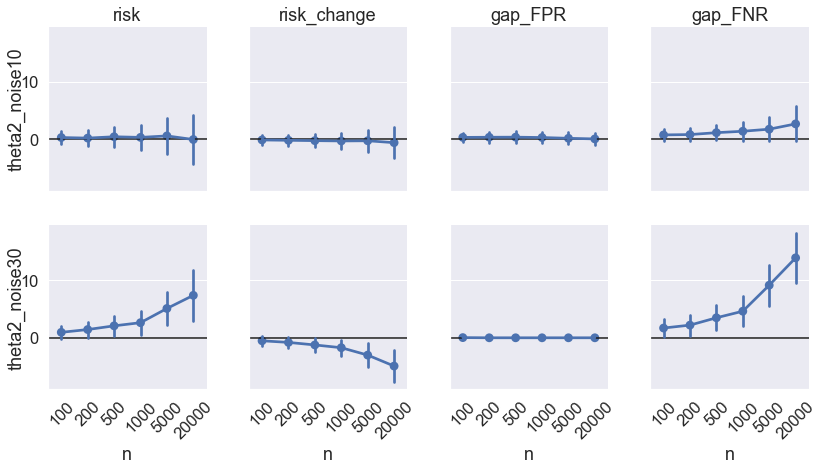

In [644]:
plot_metrics_est(metrics_est2_sr_75, metrics_pre, metrics_centered, n_arr, row = 'setting')

### Scaled by $n

In [645]:
## Scenario 1
metrics_est1_sr_100 = transform_metrics(metrics_est1_sr,
              risk = (risk_post1, risk_post1),
              risk_change = (risk_change_post1, risk_change_post1),
              epsilon_pos = (gap_FPR_post1, gap_FPR_post1),
              epsilon_neg = (gap_FNR_post1, gap_FNR_post1),
                                      scale=1.0)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


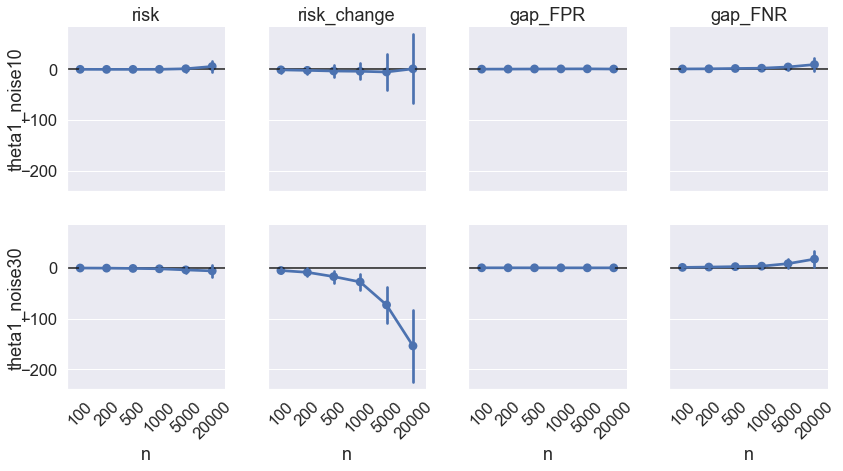

In [646]:
plot_metrics_est(metrics_est1_sr_100, metrics_pre, metrics_centered, n_arr, row = 'setting')

In [651]:
## Scenario 2
metrics_est2_sr_100 = transform_metrics(metrics_est2_sr,
              risk = (risk_post2, risk_post2),
              risk_change = (risk_change_post2, risk_change_post2),
              epsilon_pos = (gap_FPR_post2, gap_FPR_post2),
              epsilon_neg = (gap_FNR_post2, gap_FNR_post2),
                                      scale=1.0)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


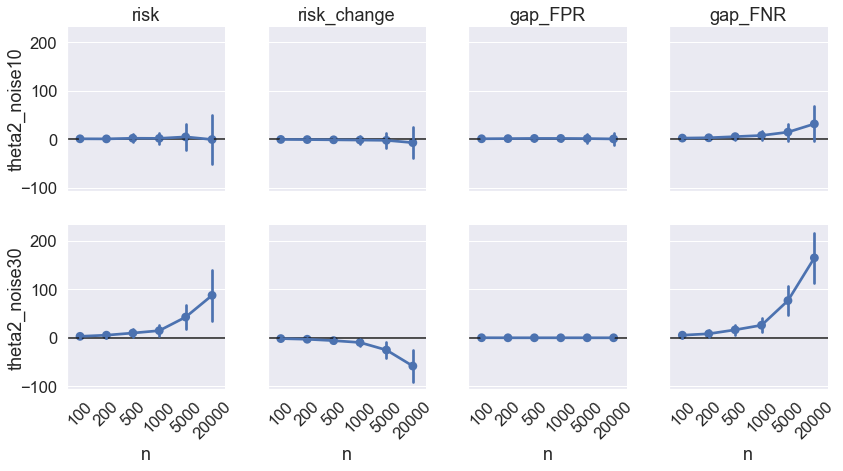

In [658]:
plot_metrics_est(metrics_est2_sr_100, metrics_pre, metrics_centered, n_arr,
                 row = 'setting')

# Plots for paper

## Explanatory Figure for Intro

In [549]:
def intro_data_pre(n, pA, need_A, strength, prob_treated):
    """Generate data."""
    A = np.random.binomial(1, p = pA, size = n)
    Y0 = np.random.binomial(1, p = A*need_A[0] + (1 - A)*need_A[1], size = n)
    Y1 = np.copy(Y0)
    Y1[Y0 == 1] = np.random.binomial(1, 1 - strength, size = np.sum(Y0))
    AY0 = pd.DataFrame({'A': A, 'Y0': Y0})
    D_probs = (1-A)*(1-Y0)*prob_treated[0] + (1-A)*Y0*prob_treated[1] +\
              A*(1-Y0)*prob_treated[2] + A*Y0*prob_treated[3]
    D = np.random.binomial(1, D_probs)
    Y = D*Y1 + (1 - D)*Y0
    out = np.concatenate([A.reshape((n,1)), Y0.reshape((n,1)),
                          Y1.reshape((n,1)), D.reshape((n,1)), 
                          Y.reshape((n,1))], axis = 1)
    out = pd.DataFrame(out, columns = ['A', 'Y0', 'Y1', 'D', 'Y'])
    
    return out

In [568]:
def intro_data_post(n, pA, need_A, strength, prob_treated_pre, pred_rates):
    out = intro_data_pre(n, pA, need_A, strength, prob_treated_pre)
    D_new_probs = pred_rates[(0, 0, 'FPR')]*(1 - out.Y)*(1 - out.A) +\
                  pred_rates[(0, 1, 'TPR')]*out.Y*(1 - out.A) +\
                  pred_rates[(1, 0, 'FPR')]*(1 - out.Y)*out.A +\
                  pred_rates[(1, 1, 'TPR')]*out.Y*out.A
    D = np.random.binomial(1, D_new_probs)
    Y = D*out.Y1 + (1 - D)*out.Y0
    out['D'] = D
    out['Y'] = Y
    
    return out

In [628]:
def calc_errors(dat, pred_rates):
    """Compute P(S = 1|Y(0) = 1, A) for different predictors S.
    
    Args:
      pred_rates: P(S = 1|A, Y), a Series with index (A, Y). 
    """
    reg_Y = dat.loc[dat.Y0 == 1].groupby('A')['Y'].mean()
    cTPR0 = pred_rates[(0, 1, 'TPR')]*reg_Y[0] + pred_rates[(0, 0, 'FPR')]*(1 - reg_Y[0])
    cTPR1 = pred_rates[(1, 1, 'TPR')]*reg_Y[1] + pred_rates[(1, 0, 'FPR')]*(1 - reg_Y[1])
    
    reg_Y = dat.loc[dat.Y0 == 0].groupby('A')['Y'].mean()
    cFPR0 = pred_rates[(0, 1, 'TPR')]*reg_Y[0] + pred_rates[(0, 0, 'FPR')]*(1 - reg_Y[0])
    cFPR1 = pred_rates[(1, 1, 'TPR')]*reg_Y[1] + pred_rates[(1, 0, 'FPR')]*(1 - reg_Y[1])
    
    out = pd.DataFrame({'A': [0, 1], 'cTPR': [cTPR0, cTPR1], 'cFPR': [cFPR0, cFPR1]})
    return out

In [591]:
def calc_success(dat):
    """Compute P(Y = 0|A), the probability of success for groups A."""
    out = (1 - dat.groupby('A')['Y'].mean()).to_frame()
    return out

In [613]:
n = 50000
pA = 0.7
need_A = [0.4, 0.2]

index = pd.MultiIndex.from_tuples([(0, 0, 'FPR'), (0, 1, 'TPR'), 
                                   (1, 0, 'FPR'), (1, 1, 'TPR')],
                                  names=['A', 'Y', 'type'])
# prob_treated = [0.6, 0.3, 0.4, 0.2]
# rates_unconstrained = pd.Series([0.3, 0.4, 0.5, 0.6], index = index)
# rates_EO = pd.Series([0.5, 0.6, 0.5, 0.6], index = index)

# prob_treated = [0.6, 0.3, 0.4, 0.2]
# rates_unconstrained = pd.Series([0.3, 0.4, 0.5, 0.6], index = index)
# rates_EO = pd.Series([0.3, 0.6, 0.3, 0.6], index = index)

prob_treated = [0.3, 0.6, 0.2, 0.4]
rates_unconstrained = pd.Series([0.2, 0.5, 0.6, 0.7], index = index)
rates_EO = pd.Series([0.1, 0.8, 0.1, 0.8], index = index)

In [629]:
strength = np.linspace(0, 1, 21)
res_obs = [None]*len(strength)
res_EO_pre = [None]*len(strength)
res_EO_post = [None]*len(strength)

for i, s in enumerate(strength):
    dat_pre = intro_data_pre(50000, pA, need_A, s, prob_treated)
    dat_post = intro_data_post(50000, pA, need_A, s, prob_treated, rates_EO)
    res_EO_pre[i] = calc_errors(dat_pre, rates_EO)
    res_obs[i] = calc_success(dat_pre)
    res_EO_post[i] = calc_success(dat_post)

res_obs = pd.concat(res_obs, axis = 0, keys = strength)
res_obs = res_obs.reset_index().rename(columns = {'level_0': 'strength'})
res_EO_pre = pd.concat(res_EO_pre, axis = 0, keys = strength)
res_EO_pre = res_EO_pre.reset_index().rename(columns = {'level_0': 'strength'}).drop(columns = 'level_1')
res_EO_post = pd.concat(res_EO_post, axis = 0, keys = strength)
res_EO_post = res_EO_post.reset_index().rename(columns = {'level_0': 'strength'})

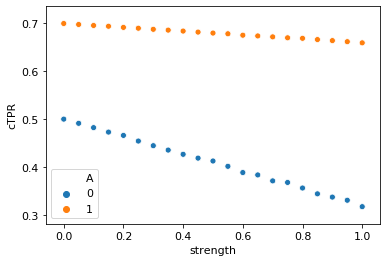

In [545]:
## No need to have the observable case
sns.scatterplot('strength', 'cTPR', hue = 'A', data = res_obs)

In [554]:
## Baseline opportunity rates
opportunity_base = dat.loc[dat.Y0 == 1].groupby('A')['D'].mean()

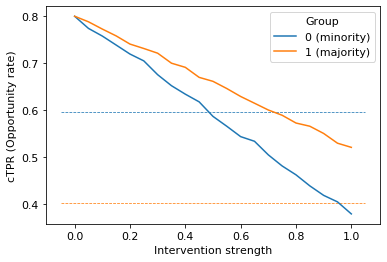

In [644]:
from matplotlib import rcParams
rcParams.update({'font.size': 11})
ax = sns.lineplot('strength', 'cTPR', hue = 'A', data = res_EO_pre)
# ax.set_ylim(0, 1)
ax.set_xlabel('Intervention strength')
ax.set_ylabel('cTPR (Opportunity rate)')
handles, labels = ax.get_legend_handles_labels()
ax.hlines(opportunity_base, *ax.get_xlim(), color = sns.color_palette()[0:2],
         linestyle = '--', linewidth=0.75)
# ax.legend(handles=handles[1:], labels=labels[1:], title = 'Group')
ax.legend(handles=handles[1:], labels=['0 (minority)', '1 (majority)'], title = 'Group')

ax.get_figure().savefig('../fig/intro_figure.pdf', pad_inches = 0)

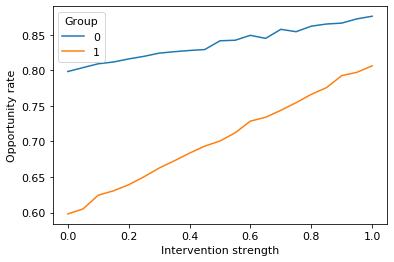

In [596]:
ax = sns.lineplot('strength', 'Y', hue = 'A', data = res_EO_post)
ax.set_xlabel('Intervention strength')
ax.set_ylabel('Success rate')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title = 'Group')

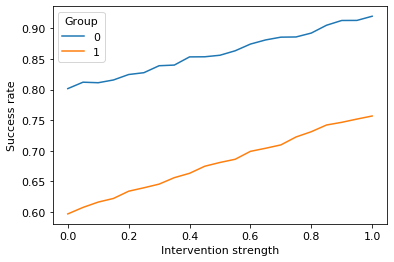

In [618]:
ax = sns.lineplot('strength', 'Y', hue = 'A', data = res_obs)
ax.set_xlabel('Intervention strength')
ax.set_ylabel('Success rate')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title = 'Group')

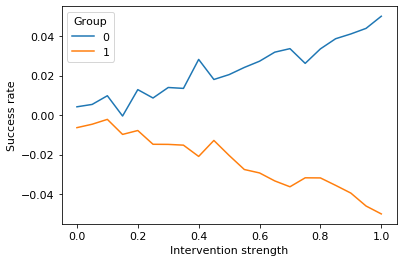

In [624]:
ax = sns.lineplot('strength', 'Y', hue = 'A', data = res_diff)
ax.set_xlabel('Intervention strength')
ax.set_ylabel('Success rate')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title = 'Group')

### Scratch: First attempt

In [63]:
def intro_data_post(n, strength, model):
    A = np.random.binomial(1, p = 0.7, size = n)
    X0 = np.random.multivariate_normal(mean = (0, 1, 2, 3), cov = np.identity(4), size = np.sum(1 - A))
    X1 = np.random.multivariate_normal(mean = (0, 1, 2, 1), cov = np.identity(4), size = np.sum(A))
    X = np.zeros((n, 4))
    X[A == 0] = X0
    X[A == 1] = X1
    Y0 = np.random.binomial(1, expit(1 - 2*A - 3*X[:, 0] + 0.5*X[:, 1] - 2*X[:, 2] + 0.4*X[:, 3]),
                            size = n)
    Y1 = np.copy(Y0)
    Y1[Y0 == 1] = np.random.binomial(1, 1 - strength, size = np.sum(Y0))
    out = np.concatenate([A.reshape((n,1)), X], axis = 1)
    out = pd.DataFrame(out, columns = ['A', 'X1', 'X2', 'X3', 'X4'])
    D = model.predict(out[['A', 'X1', 'X2', 'X3', 'X4']])
    Y = D*Y1 + (1 - D)*Y0
    out = np.concatenate([out, Y0.reshape((n,1)), Y1.reshape((n,1)),
                          D.reshape((n,1)), Y.reshape((n,1))], axis = 1)
    out = pd.DataFrame(out, columns = ['A', 'X1', 'X2', 'X3', 'X4', 'Y0', 'Y1', 'D', 'Y'])
    reg = out.groupby(['A', 'D'])[['Y0', 'Y']].mean().to_dict()
    mu = out.apply(lambda df: reg['Y'][df['A'], df['D']], axis = 1)
    mu0 = out.apply(lambda df: reg['Y0'][df['A'], df['D']], axis = 1)
    out = out.assign(mu = mu, mu0 = mu0)
    
    return out

In [79]:
def new_data_pre(n, needs_met, strength, model):
    """Add predictions from model and compute regressions needed for
    derived predictors."""
    out = intro_data_pre(n, needs_met, strength)
    out['S'] = model.predict(out[['A', 'X1', 'X2', 'X3', 'X4']])
    reg = out.groupby(['A', 'S'])[['Y0', 'Y']].mean().to_dict()
    mu = out.apply(lambda df: reg['Y'][df['A'], df['S']], axis = 1)
    mu0 = out.apply(lambda df: reg['Y0'][df['A'], df['S']], axis = 1)
    out = out.assign(mu = mu, mu0 = mu0)
    
    return out

In [31]:
def get_derived(data, A, R, outcome, epsilon_pos, epsilon_neg):
    """Optimization with precalculated regressions."""
    obj = risk_coefs(data, A=A, R=R, outcome=outcome)
    fair_pos, fair_neg = fairness_coefs(data, A=A, R=R, outcome=outcome)
    theta = optimize(obj, fair_pos, fair_neg, epsilon_pos, epsilon_neg)

    out = {'theta': theta, 'risk_coefs': obj,
           'fairness_coefs_pos': fair_pos, 'fairness_coefs_neg': fair_neg}

    return out

In [93]:
def compute_results(dat):
    out = {'AY': pd.crosstab(dat.A, dat.Y),
          'ADY': pd.crosstab(dat.A, [dat.D, dat.Y]),
          'ADY0': pd.crosstab(dat.A, [dat.D, dat.Y0])}
    return out

In [94]:
def needs_met_obs(dat):
    return dat.loc[dat['Y0'] == 1].groupby('A')['D'].mean()

In [110]:
def needs_met_derived(dat, theta_dict):
    dat = dat.assign(theta_AS = dat.apply(lambda df: theta_dict[(df['A'], df['S'])], axis = 1))
    return dat.loc[dat['Y0'] == 1].groupby('A')['theta_AS'].mean()

In [176]:
def calc_needs_met(res):
    tmp = res['ADY0']
    needs0 = tmp.loc[0, (1, 1)]/(tmp.loc[0, (0, 1)] + tmp.loc[0, (1, 1)])
    needs1 = tmp.loc[1, (1, 1)]/(tmp.loc[1, (0, 1)] + tmp.loc[1, (1, 1)])
    out = pd.DataFrame({'A': (0, 1), 'prob_served': (needs0, needs1)})
    return out

In [177]:
def calc_outcomes(res):
    tmp = res['AY']
    outcomes0 = tmp.loc[0, 0]/tmp.loc[0].values.sum()
    outcomes1 = tmp.loc[1, 0]/tmp.loc[1].values.sum()
    out = pd.DataFrame({'A': (0, 1), 'success_rate': (outcomes0, outcomes1)})
    return out

In [75]:
dat_pre.head()

,A,X1,X2,X3,X4,Y0,Y1,D,Y
0,1.0,0.784842,-0.112813,1.622358,1.282884,0.0,0.0,0.0,0.0
1,1.0,-2.581628,1.725705,1.864020,1.787700,1.0,0.0,0.0,1.0
2,1.0,1.787463,1.262535,1.524450,0.993040,0.0,0.0,0.0,0.0
3,1.0,0.049238,1.559498,2.919630,1.466951,0.0,0.0,1.0,0.0
4,1.0,0.209551,-0.070621,1.118558,1.449328,0.0,0.0,1.0,0.0


In [76]:
model = LogisticRegression()
model.fit(dat_pre[['A', 'X1', 'X2', 'X3', 'X4']], dat_pre['Y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
dat_post = intro_data_post(10000, 0.5, model)

In [80]:
dat_pre_new = new_data_pre(10000, 0.5, 0.5, model)

In [81]:
dat_pre_new.head()

,A,X1,X2,X3,X4,Y0,Y1,D,Y,S,mu,mu0
0,1.0,0.899434,0.674752,2.421140,1.001838,0.0,0.0,0.0,0.0,0.0,0.069545,0.094063
1,1.0,-0.154300,0.894204,3.363923,1.622123,0.0,0.0,0.0,0.0,0.0,0.069545,0.094063
2,1.0,-1.253850,1.304047,1.436605,-0.480590,1.0,1.0,0.0,1.0,0.0,0.069545,0.094063
3,0.0,1.799664,0.701944,1.925145,2.211406,0.0,0.0,0.0,0.0,0.0,0.137607,0.197009
4,1.0,-0.023393,1.447167,1.714529,2.344465,0.0,0.0,0.0,0.0,0.0,0.069545,0.094063


In [181]:
n = 5000
needs_met = 0.8
strength = np.linspace(0, 1, 21)
res_obs = [None]*len(strength)
res_EO = [None]*len(strength)
res_cEO = [None]*len(strength)

for i, s in enumerate(strength):
    dat_pre = intro_data_pre(n, needs_met, strength[i])
    model = LogisticRegression()
    model.fit(dat_pre[['A', 'X1', 'X2', 'X3', 'X4']], dat_pre['Y'])
    dat_pre_new = new_data_pre(n, needs_met, strength[i], model)
    dat_post = intro_data_post(n, strength[i], model)

    ## Unconstrained model
    res_obs[i] = compute_results(dat_post)
    
    ## EO model
    derived_EO = get_derived(dat_pre_new, 'A', 'S', 'mu', 1, 0.05)
    theta_dict = dict(zip([(0, 0), (0, 1), (1, 0), (1, 1)], derived_EO['theta']))
    res_EO[i] = needs_met_derived(dat_pre_new, theta_dict)

    ## cEO model
    derived_cEO = get_derived(dat_pre_new, 'A', 'S', 'mu0', 1, 0.05)
    theta_dict = dict(zip([(0, 0), (0, 1), (1, 0), (1, 1)], derived_cEO['theta']))
    res_cEO[i] = needs_met_derived(dat_pre_new, theta_dict)

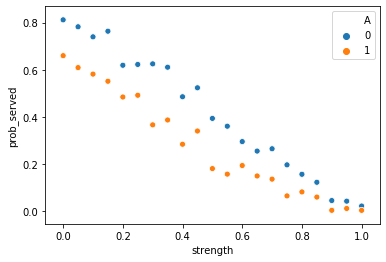

In [178]:
tmp = [calc_needs_met(rr) for rr in res_obs]
df_needs = pd.concat(tmp, axis = 0, keys = strength)
df_needs = df_needs.reset_index().drop(columns = 'level_1').rename(columns = {'level_0': 'strength'})
sns.scatterplot('strength', 'prob_served', hue = 'A', data = df_needs)

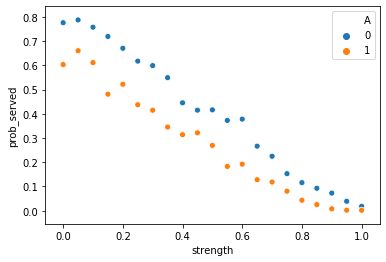

In [182]:
tmp = [calc_needs_met(rr) for rr in res_obs]
df_needs = pd.concat(tmp, axis = 0, keys = strength)
df_needs = df_needs.reset_index().drop(columns = 'level_1').rename(columns = {'level_0': 'strength'})
sns.scatterplot('strength', 'prob_served', hue = 'A', data = df_needs)

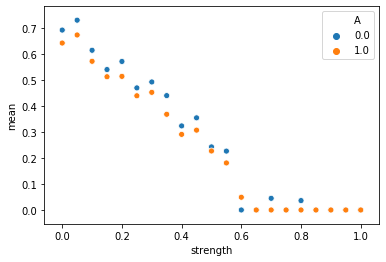

In [183]:
res_EO = pd.concat(res_EO, keys = strength).to_frame().reset_index()
res_EO = res_EO.rename(columns = {'level_0': 'strength', 'theta_AS': 'mean'})

ax = sns.scatterplot('strength', 'mean', hue = 'A', data = res_EO)

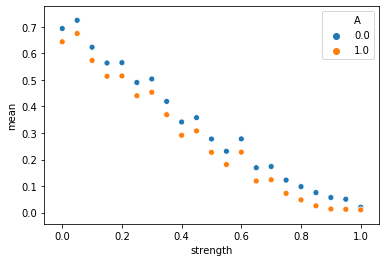

In [184]:
res_cEO = pd.concat(res_cEO, keys = strength).to_frame().reset_index()
res_cEO = res_cEO.rename(columns = {'level_0': 'strength', 'theta_AS': 'mean'})

sns.scatterplot('strength', 'mean', hue = 'A', data = res_cEO)

### Scratch: Second attempt

In [279]:
# model = LogisticRegression()
# model.fit(dat_pre[['A', 'X1', 'X2', 'X3', 'X4']], dat_pre['Y'])
# preds = model.predict_proba(dat_post[['A', 'X1', 'X2', 'X3', 'X4']])[:, 1]
# np.savetxt('../out/preds_python.csv', preds, delimiter = ',')

In [73]:
# def intro_data_pre(n, needs_met, strength):
#     A = np.random.binomial(1, p = 0.7, size = n)
#     X0 = np.random.multivariate_normal(mean = (0, 1, 2, 3), cov = np.identity(4), size = np.sum(1 - A))
#     X1 = np.random.multivariate_normal(mean = (0, 1, 2, 1), cov = np.identity(4), size = np.sum(A))
#     X = np.zeros((n, 4))
#     X[A == 0] = X0
#     X[A == 1] = X1
#     Y0 = np.random.binomial(1, expit(1 - 2*A - 3*X[:, 0] + 0.5*X[:, 1] - 2*X[:, 2] + 0.4*X[:, 3]),
#                             size = n)
#     Y1 = np.copy(Y0)
#     Y1[Y0 == 1] = np.random.binomial(1, 1 - strength, size = np.sum(Y0))
#     D = np.copy(Y0)
#     D[Y0 == 1] = np.random.binomial(1, needs_met, size = sum(Y0))
#     D[Y0 == 0] = np.random.binomial(1, needs_met/2, size = sum(1 - Y0))
#     Y = D*Y1 + (1 - D)*Y0
#     out = np.concatenate([A.reshape((n,1)), X, Y0.reshape((n,1)),
#                           Y1.reshape((n,1)), D.reshape((n,1)), Y.reshape((n,1))], axis = 1)
#     out = pd.DataFrame(out, columns = ['A', 'X1', 'X2', 'X3', 'X4', 'Y0', 'Y1', 'D', 'Y'])
    
#     return out

In [219]:
def intro_data_pre(n, needs_met, strength):
    A = np.random.binomial(1, p = 0.7, size = n)
    X = np.random.binomial(1, p = 0.6*A + 0.3*(1 - A), size = n)
    AX = pd.DataFrame({'A': A, 'X': X})
    Y0_probs_dict = {(0, 0): 0.7, (0, 1): 0.4, (1, 0): 0.4, (1, 1): 0.2}
    Y0_probs = AX.apply(lambda df:Y0_probs_dict[(df.A, df.X)], axis = 1)
    Y0 = np.random.binomial(1, p = Y0_probs, size = n)
    Y1 = np.copy(Y0)
    Y1[Y0 == 1] = np.random.binomial(1, 1 - strength, size = np.sum(Y0))
    D = np.copy(Y0)
    D[Y0 == 1] = np.random.binomial(1, needs_met, size = sum(Y0))
    D[Y0 == 0] = np.random.binomial(1, needs_met/2, size = sum(1 - Y0))
    Y = D*Y1 + (1 - D)*Y0
    out = np.concatenate([A.reshape((n,1)), X.reshape((n, 1)), Y0.reshape((n,1)),
                          Y1.reshape((n,1)), D.reshape((n,1)), Y.reshape((n,1))], axis = 1)
    out = pd.DataFrame(out, columns = ['A', 'X', 'Y0', 'Y1', 'D', 'Y'])
    reg = out.groupby(['A', 'X'])[['Y0', 'Y']].mean().to_dict()
    mu = out.apply(lambda df: reg['Y'][df['A'], df['X']], axis = 1)
    mu0 = out.apply(lambda df: reg['Y0'][df['A'], df['X']], axis = 1)
    out = out.assign(mu = mu, mu0 = mu0)
    
    return out

In [ ]:
dat_pre = intro_data_pre(10000, 0.5, 0.5)

In [232]:
theta_obs = dat_pre.groupby(['A', 'X'])['Y'].mean()

In [269]:
obj = risk_coefs(dat_pre, 'A', 'X', 'mu')
pos, neg = fairness_coefs(dat_pre, 'A', 'X', 'mu')
theta_EO = optimize(obj, pos, neg, 0.1, 0.1)

In [268]:
obj = risk_coefs(dat_pre, 'A', 'X', 'mu0')
pos, neg = fairness_coefs(dat_pre, 'A', 'X', 'mu0')
theta_cEO = optimize(obj, pos, neg, 0.1, 0.1)

In [270]:
cTPR0_obj = -np.dot(neg[0:2], theta_obs[0:2])
cTPR1_obj = np.dot(neg[2:], theta_obs[2:])
cTPR0_obj - cTPR1_obj

0.24694076173395332

In [271]:
cTPR0_EO = -np.dot(neg[0:2], theta_EO[0:2])
cTPR1_EO = np.dot(neg[2:], theta_EO[2:])
cTPR0_EO - cTPR1_EO

0.09999999979286849

In [273]:
cTPR1_EO

6.706291901716812e-11

In [274]:
cTPR0_EO

0.09999999985993141

In [316]:
cTPR0_cEO = -np.dot(neg[0:2], theta_cEO[10][0:2])
cTPR1_cEO = np.dot(neg[2:], theta_cEO[10][2:])
cTPR0_cEO - cTPR1_cEO

0.05045375014481031

In [317]:
cTPR0_cEO

0.05045375024486669

In [318]:
cTPR1_cEO

1.0005637837952532e-10

In [283]:
def compute_TPR(theta, coefs):
    cTPR0 = -np.dot(coefs[0:2], theta[0:2])
    cTPR1 = np.dot(coefs[2:], theta[2:])
    out = pd.DataFrame({'A': [0, 1], 'cTPR': [cTPR0, cTPR1]})
    return out

In [305]:
epsilon_pos = 1
epsilon_neg = 0.05
n = 10000
needs_met = 0.5
strength = np.linspace(0, 1, 21)
theta_obs = [None]*len(strength)
theta_EO = [None]*len(strength)
theta_cEO = [None]*len(strength)
res_obs = [None]*len(strength)
res_EO = [None]*len(strength)
res_cEO = [None]*len(strength)

for i, s in enumerate(strength):
    dat_pre = intro_data_pre(n, needs_met, strength[i])
    obj = risk_coefs(dat_pre, 'A', 'X', 'mu')
    pos_mu, neg_mu = fairness_coefs(dat_pre, 'A', 'X', 'mu')
    pos_mu0, neg_mu0 = fairness_coefs(dat_pre, 'A', 'X', 'mu0')
    
    ## Unconstrained model
    theta_obs[i] = dat_pre.groupby(['A', 'X'])['Y'].mean()
    res_obs[i] = compute_TPR(theta_obs[i], neg_mu0)
    
    ## EO model
    theta_EO[i] = optimize(obj, pos_mu, neg_mu, epsilon_pos, epsilon_neg)    
    res_EO[i] = compute_TPR(theta_EO[i], neg_mu0)

    ## cEO model
    theta_cEO[i] = optimize(obj, pos_mu0, neg_mu0, epsilon_pos, epsilon_neg)    
    res_cEO[i] = compute_TPR(theta_cEO[i], neg_mu0)

In [299]:
theta_EO

[array([1.86074557e-01, 5.20426555e-10, 1.70742078e-01, 1.72769427e-10]),
 array([6.19799313e-02, 1.13711529e-08, 3.44345274e-08, 1.80543285e-09]),
 array([6.16952778e-02, 2.09526790e-09, 8.03098013e-10, 2.92853963e-10]),
 array([6.23909888e-02, 1.44472221e-09, 1.91688312e-09, 1.60325610e-10]),
 array([6.20178040e-02, 1.16416819e-09, 1.11443088e-09, 1.40679755e-10]),
 array([6.23727419e-02, 2.30526722e-08, 1.34967182e-08, 3.46362877e-09]),
 array([6.26270447e-02, 1.73470045e-08, 7.38845464e-09, 2.61920521e-09]),
 array([6.33616939e-02, 1.29912218e-08, 3.21334920e-09, 1.38830704e-09]),
 array([6.25838846e-02, 1.32583204e-08, 3.07589628e-09, 1.42604632e-09]),
 array([6.30143111e-02, 6.33576708e-10, 9.19922621e-11, 4.55833222e-11]),
 array([6.37037009e-02, 7.46769276e-10, 8.81401124e-11, 4.72440760e-11]),
 array([6.10045637e-02, 5.96258559e-10, 8.15799055e-11, 4.41230397e-11]),
 array([2.66698218e-10, 5.82820105e-10, 1.03110567e-10, 5.58496320e-11]),
 array([3.10941532e-10, 6.79497754e-10

In [300]:
theta_cEO

[array([1.86074557e-01, 5.20426555e-10, 1.70742078e-01, 1.72769427e-10]),
 array([6.18815538e-02, 1.18236059e-08, 4.08391788e-08, 1.97627734e-09]),
 array([6.17283943e-02, 1.22060602e-09, 4.78662829e-10, 1.48732463e-10]),
 array([6.21712750e-02, 1.10239905e-09, 1.58614303e-09, 1.05404255e-10]),
 array([6.18224933e-02, 9.98217876e-10, 1.02426538e-09, 1.14879411e-10]),
 array([6.24142659e-02, 8.26692326e-10, 6.79273440e-10, 1.09701688e-10]),
 array([6.24077799e-02, 2.63226398e-10, 2.06087519e-10, 4.43340402e-11]),
 array([6.31524520e-02, 1.72487390e-08, 7.73457331e-09, 2.58286356e-09]),
 array([6.24830851e-02, 2.17151105e-10, 1.19381214e-10, 3.81911036e-11]),
 array([6.32623741e-02, 1.81324348e-08, 6.12197904e-09, 2.58175947e-09]),
 array([6.29099755e-02, 6.75199357e-10, 7.53618541e-11, 4.41114783e-11]),
 array([6.17607501e-02, 4.93963860e-10, 6.66365946e-11, 3.66957931e-11]),
 array([4.70191284e-10, 1.53393400e-09, 2.86660167e-10, 1.41601357e-10]),
 array([4.22558796e-10, 1.07370784e-09

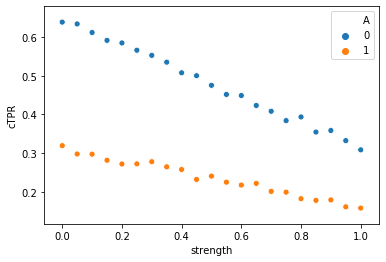

In [306]:
tmp = pd.concat(res_obs, axis = 0, keys = strength)
tmp = tmp.reset_index().rename(columns = {'level_0': 'strength'}).drop(columns = 'level_1')
sns.scatterplot('strength', 'cTPR', hue = 'A', data = tmp)

In [295]:
res_EO

,strength,A,cTPR
0,0.00,0,1.480803e-01
1,0.00,1,9.808028e-02
2,0.05,0,5.007951e-02
3,0.05,1,2.054701e-08
4,0.10,0,4.997318e-02
5,0.10,1,5.733465e-10
6,0.15,0,5.017670e-02
7,0.15,1,1.131364e-09
8,0.20,0,5.015796e-02
9,0.20,1,6.795023e-10


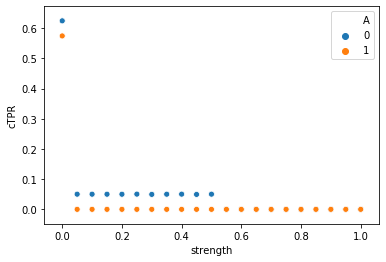

In [307]:
res_EO = pd.concat(res_EO, axis = 0, keys = strength)
res_EO = res_EO.reset_index().rename(columns = {'level_0': 'strength'}).drop(columns = 'level_1')
sns.scatterplot('strength', 'cTPR', hue = 'A', data = res_EO)

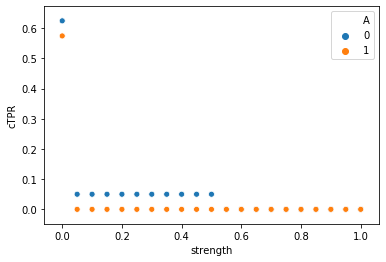

In [308]:
res_cEO = pd.concat(res_cEO, axis = 0, keys = strength)
res_cEO = res_cEO.reset_index().rename(columns = {'level_0': 'strength'}).drop(columns = 'level_1')
sns.scatterplot('strength', 'cTPR', hue = 'A', data = res_cEO)

In [310]:
tmp = pd.concat([res_EO, res_cEO], axis = 1)

In [312]:
tmp

,strength,A,cTPR,strength,A,cTPR
0,0.00,0,6.243927e-01,0.00,0,6.243927e-01
1,0.00,1,5.743927e-01,0.00,1,5.743927e-01
2,0.05,0,5.017134e-02,0.05,0,5.000000e-02
3,0.05,1,2.165808e-09,0.05,1,2.180571e-09
4,0.10,0,5.012419e-02,0.10,0,5.000000e-02
5,0.10,1,1.154925e-09,0.10,1,1.168441e-09
6,0.15,0,5.005859e-02,0.15,0,5.000000e-02
7,0.15,1,2.266901e-09,0.15,1,2.218288e-09
8,0.20,0,4.996681e-02,0.20,0,5.000000e-02
9,0.20,1,9.294951e-10,0.20,1,5.291723e-10


In [280]:
theta_obs[i]

A  X
0  0    0.708794
   1    0.414097
1  0    0.398741
   1    0.194846
Name: Y, dtype: float64

In [279]:
neg_mu0

array([-0.79686656, -0.20313344,  0.58491534,  0.41508466])

In [203]:
strength = 0.5
needs_met = 0.5

## Plotting parameters for Task 1 and Task 2 plots

In [24]:
mpl.rcParams.update(mpl.rcParamsDefault)

sns.set_style("darkgrid")
# size_ticklabels = 20  # size of tick labels, for paper
size_ticklabels = 24  # size of tick labels, for slides
# size_titles = 24      # size of axis labels and titles, for paper
size_titles = 30      # size of axis labels and titles, for slides
scale = 1.5           # size of points in the pointplot
aspect = 1.7          # aspect ratio of the facetgrids
# wspace = 0.15         # wspace argument of fig.subplots_adjust()
# hspace = 0.15         # hspace argument of fig.subplots_adjust()
wspace = 0.20         # wspace argument of fig.subplots_adjust()
hspace = 0.20         # hspace argument of fig.subplots_adjust()
labelpad = 20         # space between y-axis labels and the axis
titlepad = 10         # space between top of the plot and the titles

rcParams['axes.ymargin'] = 0.30
rcParams['ytick.labelsize'] = 20

## Task (1) plots

Setting 2 only, noise 30 only. Unscaled plot and plot scaled by $\sqrt{n}$.

### Setting 2: Unscaled

In [6]:
import os

In [19]:
# Read in previous results
with open(os.path.join(datapath, 'task1/metrics_best_2.pickle'), 'rb') as file_in:
    metrics_best_2 = pickle.load(file_in)
metrics2_30 = pd.read_csv(os.path.join(datapath, 'task1/metrics2_30.csv'))
metrics2_30_sr = pd.read_csv(os.path.join(datapath, '../out/task1/metrics2_30_sr.csv'))

In [20]:
# Additional setup
n_arr = [100, 200, 500, 1000, 5000, 20000]  # Sample sizes
risk_best2 = metrics_best_2.loc[metrics_best_2['metric'] == 'risk', 'value'].values[0]

In [21]:
metrics2_n0 = pd.concat([metrics2_30, metrics2_30_sr], keys = ['DR', 'SR'])
metrics2_n0 = metrics2_n0.reset_index().drop(columns = 'level_1').rename(columns = {'level_0': 'estimator'})

In [22]:
metrics2_n0 = metrics2_n0.pivot_table(index = ['estimator', 'n', 'mc_iter'], columns = 'metric', values = 'value')
metrics2_n0['UF_pos'] = metrics2_n0.apply(lambda df: np.max([np.abs(df['gap_FPR']) - 0.10, 0]), axis = 1)
metrics2_n0['UF_neg'] = metrics2_n0.apply(lambda df: np.max([np.abs(df['gap_FNR']) - 0.20, 0]), axis = 1)
metrics2_n0 = metrics2_n0.reset_index().melt(id_vars = ['estimator', 'n', 'mc_iter'])

Text(0.5, 1, 'UF$^-(S_\\widehat{\\theta})$')

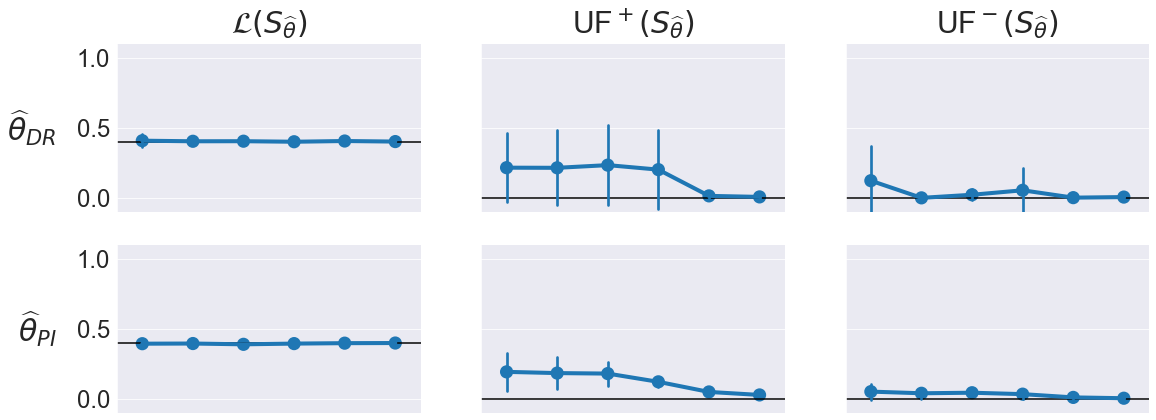

In [47]:
# %matplotlib inline
## Unscaled: 2 x 3 plot
# g = sns.FacetGrid(metrics2_n0, row = 'estimator', col = 'metric',
#                   col_order = ['risk', 'gap_FPR', 'gap_FNR'], 
#                   xlim = (min(n_arr), max(n_arr)), ylim = (-0.1, 1.1),
#                  aspect = aspect)
g = sns.FacetGrid(metrics2_n0, row = 'estimator', col = 'metric',
                  col_order = ['risk', 'UF_pos', 'UF_neg'], 
                  xlim = (min(n_arr), max(n_arr)), ylim = (-0.1, 1.1),
                 aspect = aspect)
g.map(sns.pointplot, 'n', 'value', order = n_arr, ci = 'sd', scale = scale)
g.set_titles(template='')
g.set_xticklabels('')
g.fig.subplots_adjust(wspace = wspace, hspace = hspace)

axes = g.axes
for i in [0, 1]:
    axes[i, 0].hlines(risk_best2, *axes[i, 0].get_xlim())
    axes[i, 1].hlines(0, *axes[i, 1].get_xlim())
    axes[i, 2].hlines(0, *axes[i, 2].get_xlim())
    axes[i, 0].set_yticklabels(labels = g.axes[i, 0].get_yticklabels(),
                               fontsize = size_ticklabels)
axes[0, 0].set_ylabel(r'$\widehat{\theta}_{DR}$', fontsize = size_titles, rotation = 0, va = 'center',
                   ha = 'right', labelpad = labelpad)
axes[1, 0].set_ylabel(r'$\widehat{\theta}_{PI}$', fontsize = size_titles, rotation = 0, va = 'center',
                   ha = 'right', labelpad = labelpad)
for j in range(3):
    axes[1, j].set_xlabel('')

axes[0, 0].set_title(r'$\mathcal{L}(S_\widehat{\theta})$', fontsize = size_titles,
                    pad = titlepad)
axes[0, 1].set_title(r'UF$^+(S_\widehat{\theta})$', fontsize = size_titles,
                    pad = titlepad)
axes[0, 2].set_title(r'UF$^-(S_\widehat{\theta})$', fontsize = size_titles,
                    pad = titlepad)
# axes[0, 0].set_title(r'$\mathcal{R}(R_\widehat{\theta})$', fontsize = size_titles,
#                     pad = titlepad)
# axes[0, 1].set_title(r'UF$^+(R_\widehat{\theta})$', fontsize = size_titles,
#                     pad = titlepad)
# axes[0, 2].set_title(r'UF$^-(R_\widehat{\theta})$', fontsize = size_titles,
#                     pad = titlepad)

# g.savefig(os.path.join(figpath, 'task1/task1_setting2_unscaled_L.pdf'))
# g.savefig(os.path.join(figpath, 'task1/task1_setting2_unscaled_R.pdf'))

### Setting 2: scaled by $\sqrt{n}$

In [48]:
metrics_comb_sqrt = pd.read_csv(os.path.join(datapath, 'task1/metrics_comb_sqrt.csv'))
metrics_comb_sr_sqrt = pd.read_csv(os.path.join(datapath, 'task1/metrics_comb_sr_sqrt.csv'))

In [49]:
## Scaled by \sqrt{n}: 2 x 3 plot
metrics2_sqrt = pd.concat([metrics_comb_sqrt, metrics_comb_sr_sqrt],
               keys = ['DR', 'SR'])
metrics2_sqrt = metrics2_sqrt.reset_index().drop(columns = 'level_1').rename(
    columns = {'level_0': 'estimator'})
metrics2_sqrt = metrics2_sqrt.loc[metrics2_sqrt.setting == 'Setting2_Noise30']

metrics2_sqrt = metrics2_sqrt.pivot_table(index = ['estimator', 'n', 'mc_iter'], columns = 'metric', values = 'value')
metrics2_sqrt['UF_pos'] = metrics2_sqrt.apply(lambda df: np.max([np.abs(df['gap_FPR']) - 0.10, 0]), axis = 1)
metrics2_sqrt['UF_neg'] = metrics2_sqrt.apply(lambda df: np.max([np.abs(df['gap_FNR']) - 0.20, 0]), axis = 1)
metrics2_sqrt = metrics2_sqrt.reset_index().melt(id_vars = ['estimator', 'n', 'mc_iter'])

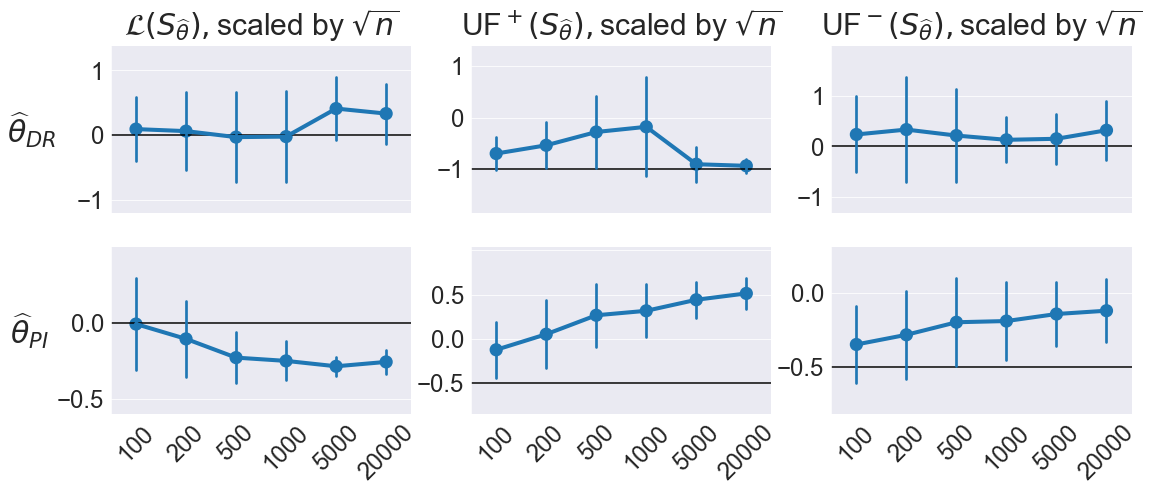

In [51]:
# g = sns.FacetGrid(metrics2_sqrt, row = 'estimator', col = 'metric',
#                   col_order = ['risk', 'gap_FPR', 'gap_FNR'], 
#                   xlim = (min(n_arr), max(n_arr)), sharey = 'none',
#                  aspect = aspect)
g = sns.FacetGrid(metrics2_sqrt, row = 'estimator', col = 'metric',
                  col_order = ['risk', 'UF_pos', 'UF_neg'], 
                  xlim = (min(n_arr), max(n_arr)), sharey = 'none',
                 aspect = aspect)
g.map(sns.pointplot, 'n', 'value', order = n_arr, ci = 'sd', scale = scale)
g.set_titles(template='')
g.set_xticklabels(rotation = 45, fontsize = size_ticklabels)
g.fig.subplots_adjust(wspace = wspace, hspace = hspace)

axes = g.axes
for ax in axes.flatten():
    ax.hlines(0, *ax.get_xlim())
axes[0, 0].set_ylabel(r'$\widehat{\theta}_{DR}$', rotation = 0, va = 'center', fontsize = size_titles,
                   ha = 'right', labelpad = labelpad)
axes[1, 0].set_ylabel(r'$\widehat{\theta}_{PI}$', rotation = 0, va = 'center', fontsize = size_titles,
                   ha = 'right', labelpad = 8)
for i in [0, 1]:
    for j in [0, 1, 2]:
        axes[i, j].set_yticklabels(labels = g.axes[i, 0].get_yticklabels(),
                             fontsize = size_ticklabels)
for j in range(3):
    axes[1, j].set_xlabel('')

axes[0, 0].set_title(r'$\mathcal{L}(S_\widehat{\theta}), $' 'scaled by ' '$\sqrt{n}$',
                     fontsize = size_titles, pad = titlepad)
axes[0, 1].set_title(r'UF$^+(S_\widehat{\theta}), $' 'scaled by ' '$\sqrt{n}$',
                     fontsize = size_titles, pad = titlepad)
axes[0, 2].set_title(r'UF$^-(S_\widehat{\theta}), $' 'scaled by ' '$\sqrt{n}$',
                     fontsize = size_titles, pad = titlepad)
# axes[0, 0].set_title(r'$\mathcal{R}(R_\widehat{\theta}), $' 'scaled by ' '$\sqrt{n}$',
#                      fontsize = size_titles, pad = titlepad)
# axes[0, 1].set_title(r'UF$^+(R_\widehat{\theta}), $' 'scaled by ' '$\sqrt{n}$',
#                      fontsize = size_titles, pad = titlepad)
# axes[0, 2].set_title(r'UF$^-(R_\widehat{\theta}), $' 'scaled by ' '$\sqrt{n}$',
#                      fontsize = size_titles, pad = titlepad)

g.savefig(os.path.join(figpath, 'task1/task1_setting2_sqrt_L.pdf'))
# g.savefig('../fig/task1/task1_setting2_sqrt_R.pdf')

## Task (2) plots
Scenario 2 only. 2x3 plots of unscaled and $\sqrt{n}$-scaled only. Only using noise level 30, not noise 10.

In [52]:
# Read in previous results
metrics_est2_30 = pd.read_csv(os.path.join(datapath, 'task2/metrics_est2_30_logit.csv'))
metrics_est2_30_sr = pd.read_csv(os.path.join(datapath, 'task2/metrics_est2_30_sr.csv'))
metrics_post2 = pd.read_csv(os.path.join(datapath, 'task2/metrics_post2.csv'))

In [53]:
# risk_post1 = metrics_post1.loc[metrics_post1['metric'] == 'risk', 'value'].values[0]
# risk_change_post1 = metrics_post1.loc[metrics_post1['metric'] == 'risk_change', 'value'].values[0]
# gap_FPR_post1 = metrics_post1.loc[metrics_post1['metric'] == 'gap_FPR', 'value'].values[0]
# gap_FNR_post1 = metrics_post1.loc[metrics_post1['metric'] == 'gap_FNR', 'value'].values[0]

risk_post2 = metrics_post2.loc[metrics_post2['metric'] == 'risk', 'value'].values[0]
risk_change_post2 = metrics_post2.loc[metrics_post2['metric'] == 'risk_change', 'value'].values[0]
gap_FPR_post2 = metrics_post2.loc[metrics_post2['metric'] == 'gap_FPR', 'value'].values[0]
gap_FNR_post2 = metrics_post2.loc[metrics_post2['metric'] == 'gap_FNR', 'value'].values[0]

### Scenario 2: Unscaled

In [78]:
# metrics2_est = pd.concat([metrics_est2, metrics_est2_sr],
#                         keys = ['DR', 'SR'], names = 'estimator')
# metrics2_est = metrics2_est.loc[metrics2_est.scenario == 'theta2_noise30']
# metrics2_est = metrics2_est.reset_index().drop(columns = ['level_1', 'scenario']).rename(columns = {'level_0': 'estimator'})

In [54]:
metrics_est2_30['scenario'] = 'theta2_noise30'
metrics_est2_30_sr['scenario'] = 'theta2_noise30'

In [55]:
metrics2_est = pd.concat([metrics_est2_30, metrics_est2_30_sr],
                        keys = ['DR', 'SR'], names = ['estimator', 'dummy'])
metrics2_est = metrics2_est.reset_index().drop(columns = ['dummy'])

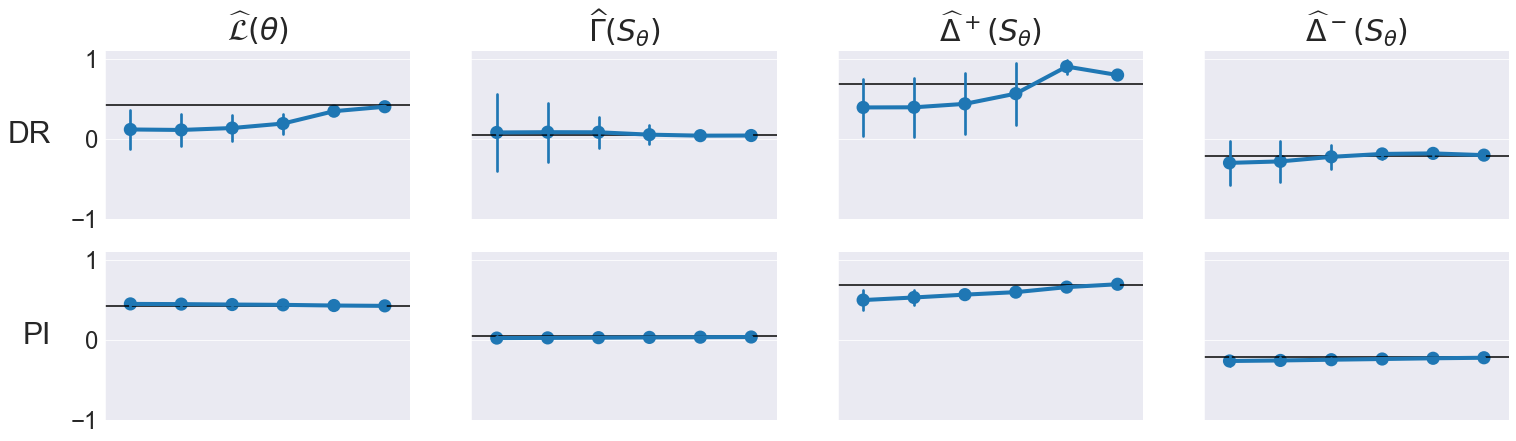

In [57]:
## Unscaled: 2 x 3 plot
g = sns.FacetGrid(metrics2_est, row = 'estimator', col = 'metric',
                  col_order = ['risk', 'risk_change', 'gap_FPR', 'gap_FNR'], 
                  xlim = (min(n_arr), max(n_arr)), ylim = (-1.0, 1.1), aspect = aspect)
g.map(sns.pointplot, 'n', 'value', order = n_arr, ci = 'sd', scale = scale)
g.set_titles(template='')
g.set_xticklabels('')
g.fig.subplots_adjust(wspace = wspace, hspace = hspace)

axes = g.axes
for i in [0, 1]:
    axes[i, 0].hlines(risk_post2, *axes[i, 0].get_xlim())
    axes[i, 1].hlines(risk_change_post2, *axes[i, 0].get_xlim())
    axes[i, 2].hlines(gap_FPR_post2, *axes[i, 1].get_xlim())
    axes[i, 3].hlines(gap_FNR_post2, *axes[i, 2].get_xlim())
    axes[i, 0].set_yticklabels(labels = g.axes[i, 0].get_yticklabels(),
                             fontsize = size_ticklabels)

axes[0, 0].set_ylabel('DR', fontsize = size_titles, rotation = 0, va = 'center',
                   ha = 'right', labelpad = labelpad)
axes[1, 0].set_ylabel('PI', fontsize = size_titles, rotation = 0, va = 'center',
                   ha = 'right', labelpad = labelpad)
for j in range(4):
    axes[1, j].set_xlabel('')

axes[0, 0].set_title(r'$\widehat{\mathcal{L}}(\theta)$', fontsize = size_titles,
                    pad = titlepad)
# axes[0, 0].set_title(r'$\widehat{\mathcal{R}}(R_\theta)$', fontsize = size_titles,
#                     pad = titlepad)
axes[0, 1].set_title(r'$\widehat{\Gamma}(S_\theta)$', fontsize = size_titles,
                    pad = titlepad)
axes[0, 2].set_title(r'$\widehat{\Delta}^+(S_\theta)$', fontsize = size_titles,
                    pad = titlepad)
axes[0, 3].set_title(r'$\widehat{\Delta}^-(S_\theta)$', fontsize = size_titles,
                    pad = titlepad)

g.savefig(os.path.join(figpath, 'task2/task2_scenario2_unscaled_L.pdf'))
# g.savefig('../fig/task2/task2_scenario2_unscaled_R.pdf')

### Scenario 2: Scaled by $\sqrt{n}$

In [58]:
metrics_est2_sqrt = transform_metrics(metrics_est2_30,
              risk = (risk_post2,), risk_change = (risk_change_post2,),
              epsilon_pos = (gap_FPR_post2,), epsilon_neg = (gap_FNR_post2,),
                                      scale=0.5)

metrics_est2_sr_sqrt = transform_metrics(metrics_est2_30_sr,
              risk = (risk_post2,), risk_change = (risk_change_post2,),
              epsilon_pos = (gap_FPR_post2,), epsilon_neg = (gap_FNR_post2,),
                                      scale=0.5)

In [59]:
metrics2_est_sqrt = pd.concat([metrics_est2_sqrt, metrics_est2_sr_sqrt],
                              keys = ['n50_DR', 'n50_SR'])
metrics2_est_sqrt = metrics2_est_sqrt.reset_index().drop(columns = 'level_1').rename(
    columns = {'level_0': 'estimator'})
# metrics2_est_sqrt = metrics2_est_sqrt.loc[metrics2_est_sqrt.scenario == 'theta2_noise30']

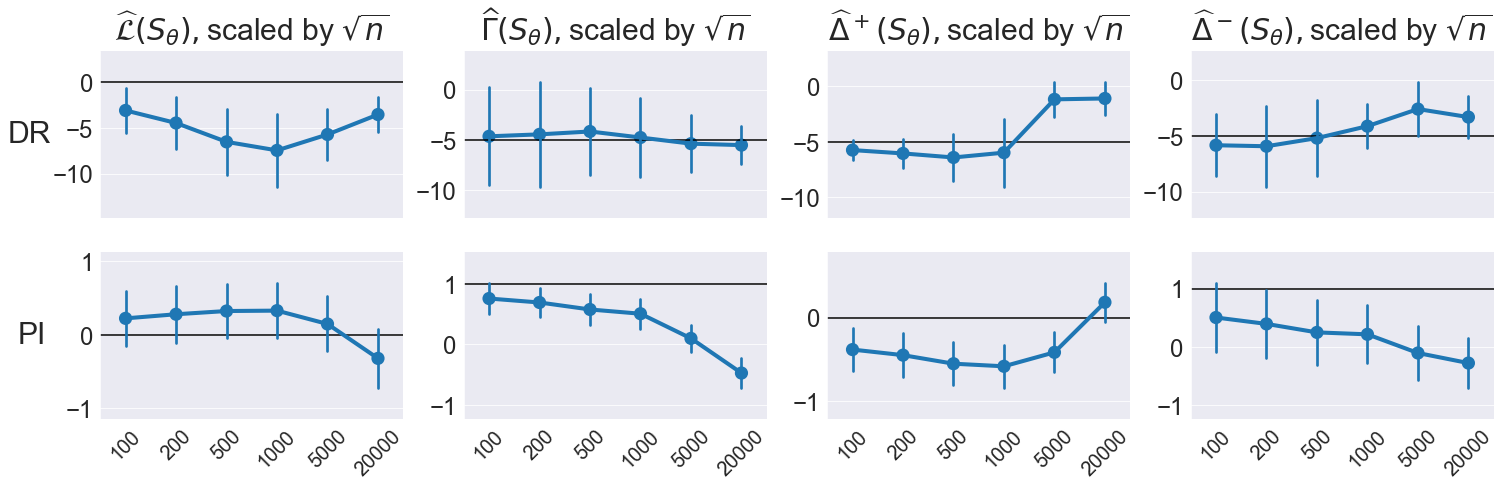

In [61]:
g = sns.FacetGrid(metrics2_est_sqrt, row = 'estimator', col = 'metric',
                  col_order = ['risk', 'risk_change', 'gap_FPR', 'gap_FNR'], 
                  xlim = (min(n_arr), max(n_arr)), sharey = 'none', aspect = aspect)
g.map(sns.pointplot, 'n', 'value', order = n_arr, ci = 'sd', scale = scale)
g.set_titles(template='')
g.set_xticklabels(rotation = 45, fontsize = 20)
g.fig.subplots_adjust(wspace = wspace, hspace = hspace)

axes = g.axes
for ax in axes.flatten():
    ax.hlines(0, *ax.get_xlim())

axes[0, 0].set_ylabel('DR', fontsize = size_titles, rotation = 0, va = 'center',
                   ha = 'right', labelpad = 2)
axes[1, 0].set_ylabel('PI', fontsize = size_titles, rotation = 0, va = 'center',
                   ha = 'right', labelpad = labelpad)
for j in range(4):
    axes[1, j].set_xlabel('')

for i in [0, 1]:
    for j in [0, 1, 2, 3]:
        axes[i, j].set_yticklabels(labels = g.axes[i, 0].get_yticklabels(),
                             fontsize = size_ticklabels)
        
# axes[0, 0].set_title(r'$\widehat{\mathcal{R}}(\theta)$', fontsize = size_titles)
# axes[0, 1].set_title(r'$\widehat{\Gamma}(\theta)$', fontsize = size_titles)
# axes[0, 2].set_title(r'$\widehat{\Delta}^+(\theta)$', fontsize = size_titles)
# axes[0, 3].set_title(r'$\widehat{\Delta}^-(\theta)$', fontsize = size_titles)

axes[0, 0].set_title(r'$\widehat{\mathcal{L}}(S_\theta), $' 'scaled by ' '$\sqrt{n}$', fontsize = size_titles,
                    pad = titlepad)
# axes[0, 0].set_title(r'$\widehat{\mathcal{R}}(S_\theta), $' 'scaled by ' '$\sqrt{n}$', fontsize = size_titles,
#                     pad = titlepad)
axes[0, 1].set_title(r'$\widehat{\Gamma}(S_\theta), $' 'scaled by ' '$\sqrt{n}$', fontsize = size_titles,
                    pad = titlepad)
axes[0, 2].set_title(r'$\widehat{\Delta}^+(S_\theta), $' 'scaled by ' '$\sqrt{n}$', fontsize = size_titles,
                    pad = titlepad)
axes[0, 3].set_title(r'$\widehat{\Delta}^-(S_\theta), $' 'scaled by ' '$\sqrt{n}$', fontsize = size_titles,
                    pad = titlepad)

g.savefig(os.path.join(figpath, 'task2/task2_scenario2_sqrt_L.pdf'))
# g.savefig('../fig/task2/task2_scenario2_sqrt_R.pdf')

## Simulating Performance decrements

The goal here is to visualize the tradeoff between performance and accuracy. We start with a perfect predictor of $Y_0$ (not of $Y$) and get the optimal derived predictor over a grid of values for $(\epsilon^+, \epsilon^-)$.

The data generating process used in the other simulations results in a Bayes-optimal predictor with error rate differences around 0.05, so there's not much room to show tradeoffs. Hence we define a new data generating process just for this section.

In [242]:
def generate_data_new(n, prob_A, beta_X, beta_D, beta_Y0, beta_Y1,
                      trunc_pi=0.975):
    """Generate sample data at time 0, including counterfactual outcomes.

    Here, D doesn't depend on R, since R hasn't been generated yet.
    """
    A = np.random.binomial(1, 0.3, size=(n, 1))
    X = np.random.normal(beta_X * A, size=(n, 4))
    AX = np.concatenate([A, X], axis=1)

    D_probs = expit(0.5 * np.dot(AX, beta_D)).clip(max=trunc_pi).reshape((n, 1))
    D = np.random.binomial(n=1, p=D_probs).reshape((n, 1))

    Y0_probs = expit(np.dot(AX, beta_Y0)).reshape((n, 1))
    Y0 = np.random.binomial(n=1, p=Y0_probs)
    Y1_probs = expit(np.dot(AX, beta_Y1)).reshape((n, 1))
    Y1 = np.random.binomial(n=1, p=Y1_probs)
    Y = D * Y1 + (1 - D) * Y0

    data = np.concatenate([AX, D, Y0, Y1, D_probs, Y0_probs, Y], axis=1)
    data = pd.DataFrame(data, columns=['A', 'X1', 'X2', 'X3', 'X4', 'D', 'Y0',
                                       'Y1', 'pi', 'mu0', 'Y'])

    return data

In [243]:
def performance_loss(data_params, epsilon_pos, epsilon_neg, n=500000):
    """Calculate performance-fairness tradeoff for optimal input predictor.
    
    Optimal input predictor refers to the Bayes-optimal predictor of Y0, not Y.
    """
    ## Generate data
    data_train = generate_data_new(n, **data_params)
    data_train['R'] = (data_train.mu0 > 0.5).astype(float)  
    data_val = generate_data_new(n, **data_params)
    data_val['R'] = (data_val.mu0 > 0.5).astype(float)  
    
    ## Get 'true' loss and fairness constraints
    coefs_obj = risk_coefs(data_train, 'A', 'R', 'mu0')
    coefs_pos, coefs_neg = fairness_coefs(data_train, 'A', 'R', 'mu0')

    ## Get best derived predictor
    theta = optimize(coefs_obj, coefs_pos, coefs_neg, epsilon_pos, epsilon_neg)    
    out = metrics(theta, data_val, outcome='mu0', ci=None)
    out = out.assign(epsilon_pos = epsilon_pos, epsilon_neg = epsilon_neg)
    
    return out

In [267]:
## Different beta_Y0 than what was used for the previous simulations.

prob_A = 0.3
beta_X = [1, -0.8, 4, 2]
beta_D_pre = [0.2, -1, 1, -1, 1]
# beta_Y0 = [-5, 2, -3, 4, -5]
beta_Y0 = [-4, 2/5.0, -3/5.0, 4/5.0, -1]
beta_Y1 = [1, -2, 3, -4, 5]

A = 'A'
X = ['X1', 'X2', 'X3', 'X4']
R = 'R'
D = 'D'
Y = 'Y'

data_params_pre = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_pre,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
}

In [264]:
dat = generate_data_new(50000, **data_params_pre)
# sns.distplot(dat.mu0)

Cross-tabs for sensitive feature A, decision D, potential outcome Y0, and observable outcome Y.
---------------
D      0.0    1.0
A                
0.0  17543  17453
1.0  12276   2728
---------------
Y0     0.0    1.0
A                
0.0  17511  17485
1.0  12049   2955
---------------
Y      0.0    1.0
A                
0.0  12893  22103
1.0  11580   3424
---------------

How often Y = Y0: 0.72986 

Properties of input predictor R

-------------------------
Confusion matrix for Y, R
-------------------------
[[0.3148  0.17466]
 [0.30616 0.20438]] 

------------------------------
Classification report for Y, R
------------------------------
              precision    recall  f1-score   support

       Y = 0       0.51      0.64      0.57     24473
       Y = 1       0.54      0.40      0.46     25527

    accuracy                           0.52     50000
   macro avg       0.52      0.52      0.51     50000
weighted avg       0.52      0.52      0.51     50000
 

---------------------

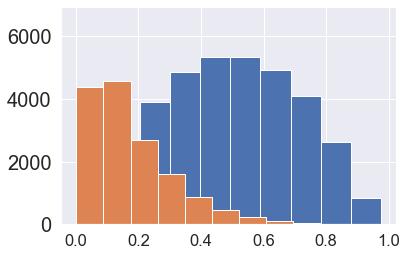

In [261]:
dat['R'] = (dat.mu0 >= 0.5).astype(float)
check_data_post(dat)

In [262]:
# Performance for the Bayes-optimal binary predictor in A, X
metrics([0, 1, 0, 1], dat, outcome='mu0', ci=None)

,metric,value,ci_lower,ci_upper
0,risk,0.239202,None,None
1,risk_change,0.000000,None,None
0,FPR0,0.269666,None,None
1,FPR1,0.042405,None,None
2,gap_FPR,0.227261,None,None
0,FNR0,0.269871,None,None
1,FNR1,0.678374,None,None
2,gap_FNR,-0.408504,None,None


In [268]:
## Get optimal derived predictor for each combo of unfairness tolerances

vals = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1] +\
       [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
res = [None]*len(vals)**2

for i, (epsilon_pos, epsilon_neg) in enumerate(itertools.product(vals, vals)):
    if i % 10 == 0:
        print(i)
    res[i] = performance_loss(data_params_pre, epsilon_pos, epsilon_neg, n = 100000)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


In [271]:
res = pd.concat(res)
res.to_csv('../out/task3/optimal_predictors_grid.csv', index = False)
# res_backup = copy.deepcopy(res)

In [272]:
res_array = res[res.metric == 'risk_change'].pivot(index='epsilon_neg',
                                                   columns='epsilon_pos',
                                                   values='value')
# res_array = res_array.sort_index(ascending = False)

In [273]:
res_array = res_array.reindex(sorted(res_array.columns, reverse = True), axis = 1)

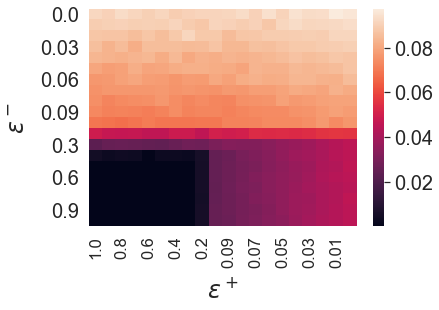

In [274]:
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True
# cmap = sns.cm.rocket_r
ax = sns.heatmap(res_array)
ax.set_xlabel(r'$\epsilon^+$', fontsize = size_titles, labelpad = 10)
ax.set_ylabel(r'$\epsilon^-$', fontsize = size_titles, labelpad = 10)
mpl.rcParams['text.usetex'] = False

In [279]:
0.239202 + res_array.iloc[0, 19]

0.33518090979172493

In [221]:
ax.get_figure().savefig('../fig/performance_tradeoff.pdf', bbox_inches = 'tight')

## Plot for proposal slides
Simple hypothetical illustration of an oEO vs a cEO predictor

In [152]:
dat = pd.DataFrame({'predictor': ['oEO', 'oEO', 'cEO', 'cEO'],
                    'S': [0, 1, 0, 1],  # using S as sensitive feature here
                    'cTPR': [0.7, 0.55, 0.83, 0.83]})

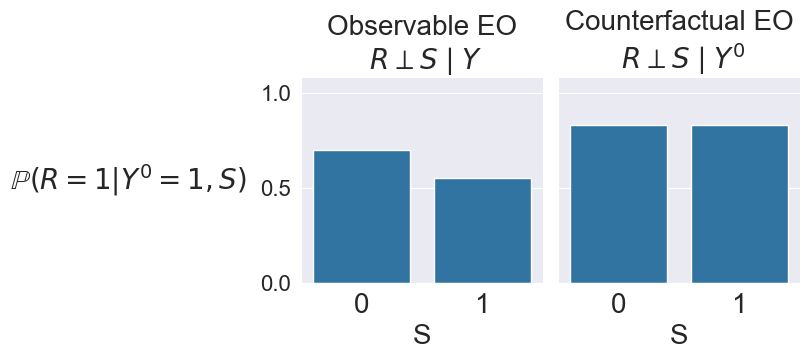

In [154]:
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

g = sns.FacetGrid(col = 'predictor', col_order = ['oEO', 'cEO'], data = dat)
g.map(sns.barplot, 'S', 'cTPR', order = [0, 1])

g.set_titles(template='')
g.set_xticklabels(fontsize = 20)
g.set_titles(fontsize = 20)
# g.fig.subplots_adjust(wspace = wspace, hspace = hspace)

axes = g.axes
# for ax in axes.flatten():
#     ax.hlines(0, *ax.get_xlim())

# axes[0, 0].set_title(r'$\widehat{\mathcal{R}}(\theta)$', fontsize = size_titles)

axes[0, 0].set_ylabel(r'$\mathbb{P}(R = 1|Y^0 = 1, S)$', fontsize = 20, rotation = 0, va = 'center',
                   ha = 'right', labelpad = 10)
# axes[1, 0].set_ylabel('SR', fontsize = size_titles, rotation = 0, va = 'center',
#                    ha = 'right', labelpad = labelpad)
# for j in range(4):
#     axes[1, j].set_xlabel('')
axes[0, 0].set_title('Observable EO\n $R\perp S\mid Y$', fontsize = 20)
axes[0, 1].set_title('Counterfactual EO\n $R\perp S\mid Y^0$', fontsize = 20)
# axes[0, 0].set_xlabel('Sensitive Feature', fontsize = 20)
# axes[0, 1].set_xlabel('S', fontsize = 20)

for j in [0, 1]:
    axes[0, j].set_xlabel('S', fontsize = 20)


g.savefig('../fig/oEO_vs_cEO.pdf')

# Dummy heading for scrolling purposes